![qqq](../resources/header.jpg)

**Машинное обучение**
***

О сайте **Backloggd.com**:

"**Backloggd** — это место для хранения вашей личной коллекции видеоигр. Каждая игра со всех платформ доступна для вас, чтобы вы могли войти в свой журнал. Следуйте за друзьями, чтобы поделиться своими отзывами и сравнить рейтинги. Затем используйте фильтры, чтобы отсортировать свою коллекцию и посмотреть, что для вас важно. Ведите список того, во что вы сейчас играете и во что хотите играть, и наблюдайте, как цифры меняются по мере того, как вы продолжаете записывать свои прохождения. Есть Goodreads для книг, Letterboxd для фильмов и теперь Backloggd для игр.

Все метаданные, связанные с игрой, поступают из базы данных **[IGDB](https://www.igdb.com/)**, управляемой сообществом . Сюда входят все данные об играх, компаниях и платформах, которые вы видите на сайте." - с сайта **[backloggd.com](https://www.backloggd.com/)**.

**Цель машинного обучения**: на основе подготовленных и предварительно обработанных данных,  обуитье модеьи, предсказываюуюй игровые жанры,к к которым принадлежит видеоигра с заданным описание    Выраатьтка сисуемы по оценке эффективности модели.

**Этапы машинного обучения**:
1. [Обзор данных](#Обзор-данных).
2. [Предобработка данных](#Предобработка-данных)
3. [Машинное обучение](#Машинное-обучение):
    - [Отбор данных](#Отбор-данных);
    - [Анализ баланса классов](#Анализ-баланса-классов);
    - [Предобработка текста](#Предобработка-текста);
    - [Разделение на выборки](#Разделение-на-выборки)
    - [Тестирование моделей](#Тестирование-моделей)
        - [Тестирование ComplementNB](#Тестирование-ComplementNB)
        - [Тестирование SGDClassifier](#Тестирование-SGDClassifier)
        - [Выводы по тестированию моделей](#Выводы-по-тестированию-моделей)
    - [Генерация признаков](#Генерация-признаков)
        - [ComplementNB](#ComplementNB)
        - [SGDClassifier](#SGDClassifier)
        - [Выводы по генерации признаков](#Выводы-по-генерации-признаков)
    - [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке)
4. [Выводы](#Выводы)
***

In [1]:
import sys

In [2]:
sys.path.append('C:\Projects\Backloggd')
sys.path.append('C:\Projects\Backloggd\src')

In [3]:
import ast
import re
import string

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MultiLabelBinarizer

from config.ml import FIT_CV_SPLITTING_STRATEGY
from config.ml import FIT_CV_VERBOSE
from config.ml import LEARNING_CURVE_SPLITTING_STRATEGY_N_SPLITS
from config.ml import LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE
from config.ml import LEARNING_CURVE_SPLITTING_STRATEGY_TRAIN_SIZES
from config.ml import LEARNING_CURVE_VERBOSE
from config.ml import N_JOBS
from config.ml import RANDOM_STATE
from config.ml import TEST_SIZE
from config.paths import FILE_PREPROCESSED_PATH
from utils.explorer import explorer
from utils.ml.features import generate
from utils.ml.plot import balance
from utils.ml.plot import calibration
from utils.ml.plot import metrics
from utils.ml.plot import scalability
from utils.ml.plot import words
from utils.ml.plot.step import step
from utils.ml.preprocessing import cleaning
from utils.ml.preprocessing import lemmatization
from utils.ml.preprocessing import stop_words
from utils.ml.remove import remove

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gsimo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsimo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gsimo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
sns.set_style('white')

In [5]:
print(explorer(FILE_PREPROCESSED_PATH, '*.csv'))

1. backloggd.csv.
2. example.csv.


In [6]:
FILE_PATH = FILE_PREPROCESSED_PATH + r'\backloggd.csv'

# Обзор данных
***

In [7]:
df = pd.read_csv(FILE_PATH)

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105001 entries, 0 to 105000
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   name         105001 non-null  object 
 1   date         105001 non-null  object 
 2   developers   105001 non-null  object 
 3   indie        105001 non-null  bool   
 4   rating       65983 non-null   float64
 5   platforms    105001 non-null  object 
 6   genres       105001 non-null  object 
 7   category     105001 non-null  object 
 8   reviews      105001 non-null  int64  
 9   plays        105001 non-null  int64  
 10  playing      105001 non-null  int64  
 11  backlogs     105001 non-null  int64  
 12  wishlists    105001 non-null  int64  
 13  description  99591 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(7)
memory usage: 93.0 MB


In [9]:
df.head()

,name,date,developers,indie,rating,platforms,genres,category,reviews,plays,playing,backlogs,wishlists,description
0,Cathode Ray Tube Amusement Device,1947-12-31,[],False,3.516129,['Analogue electronics'],['Point-and-Click'],main,43,80,1,14,34,The cathode ray tube amusement device is the e...
1,Bertie the Brain,1950-08-25,['Josef Kates'],False,2.916667,['Arcade'],"['Puzzle', 'Tactical']",main,7,10,0,5,7,Currently considered the first videogame in hi...
2,Nim,1951-12-31,[],False,2.000000,['Ferranti Nimrod Computer'],"['Pinball', 'Strategy']",main,1,2,0,1,0,The Nimrod was a special purpose computer that...
3,Draughts,1952-08-31,['Christopher Strachey'],False,1.166667,['Legacy Computer'],['Card & Board Game'],main,3,7,0,2,1,A game of draughts (a.k.a. checkers) written f...
4,OXO,1952-12-31,"['Alexander Shafto ""Sandy"" Douglas', 'Universi...",False,3.025000,"['Windows PC', 'EDSAC']","['Puzzle', 'Strategy']",main,13,34,0,8,8,OXO was a computer game developed by Alexander...


In [10]:
df.sample(5)

,name,date,developers,indie,rating,platforms,genres,category,reviews,plays,playing,backlogs,wishlists,description
82766,Traffic,2022-09-02,[],True,3.250000,['Windows PC'],['Adventure'],main,1,2,0,2,1,Traffic is an Atmospheric First-Person Psychol...
33887,Deer Hunter Reloaded,2012-02-03,['Glu Mobile'],False,0.500000,"['Android', 'iOS']",[],main,0,6,0,0,0,The most REALISTIC and AUTHENTIC hunting sim r...
64550,Demon Blade,2019-09-30,[],False,3.000000,['Android'],"['Fighting', 'RPG']",main,0,2,0,0,0,Join the league of demon hunters and save the ...
78841,Internet Cafe Simulator 2,2022-01-07,[],True,2.285714,['Windows PC'],"['Adventure', 'Simulator', 'Strategy']",main,3,54,0,7,8,Internet Cafe Simulator 2 is an extremely comp...
50769,Mono,2017-03-24,['JeliLiam'],True,NaN,['Windows PC'],['Puzzle'],main,0,0,0,0,0,Mono is compilation of 3 short horror stories ...


In [11]:
df.tail()

,name,date,developers,indie,rating,platforms,genres,category,reviews,plays,playing,backlogs,wishlists,description
104996,Resident Evil 4: The Mercenaries - Separate Wa...,2023-09-21,['Capcom'],False,4.321429,"['Windows PC', 'PlayStation 4', 'PlayStation 5...",[],update,3,21,3,3,4,A free update for The Mercenaries mode releasi...
104997,Storyteller: Devilish Update,2023-09-26,['Annapurna Interactive'],False,3.000000,"['Windows PC', 'Android', 'iOS', 'Nintendo Swi...",[],update,1,1,0,1,0,The first update of Storyteller brings the Dev...
104998,Genshin Impact: To the Stars Shining in the De...,2023-09-27,"['Cognosphere', 'HoYoverse']",False,4.000000,"['Windows PC', 'Android', 'PlayStation 4', 'iO...","['Adventure', 'RPG']",update,3,8,5,2,0,"Version 4.1 of Genshin Impact, which includes:..."
104999,Sonic Frontiers: The Final Horizon,2023-09-28,"['Sega', 'Sonic Team']",False,2.820796,"['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'Platform']",update,143,265,77,59,26,Rewrite your destiny in The Final Horizon Upda...
105000,Among Us: The Fungle,2023-10-01,['Innersloth'],True,NaN,"['Windows PC', 'Android', 'PlayStation 4', 'iO...",['Strategy'],update,0,1,0,0,1,This free update adds a new map with new tasks...


# Предобработка данных

Изменим типы данных:
- для поля **'date'** изменим тип данных на **'datetime'**;
- для **числовых полей**, уменьшим точность до **32 бит**;
- поля **'developers'**, **'platforms'** и **'genres'** приведем к типу **list**.

In [12]:
df.dtypes

name            object
date            object
developers      object
indie             bool
rating         float64
platforms       object
genres          object
category        object
reviews          int64
plays            int64
playing          int64
backlogs         int64
wishlists        int64
description     object
dtype: object

In [13]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['date'].head()

0   1947-12-31
1   1950-08-25
2   1951-12-31
3   1952-08-31
4   1952-12-31
Name: date, dtype: datetime64[ns]

In [14]:
df = df.astype({
    'rating': 'float32',
    'plays': 'int32',
    'playing': 'int32',
    'backlogs': 'int32',
    'wishlists': 'int32',
    'reviews': 'int32'
})

In [15]:
df.dtypes

name                   object
date           datetime64[ns]
developers             object
indie                    bool
rating                float32
platforms              object
genres                 object
category               object
reviews                 int32
plays                   int32
playing                 int32
backlogs                int32
wishlists               int32
description            object
dtype: object

In [16]:
df['developers'] = df['developers'].apply(ast.literal_eval)
df['platforms'] = df['platforms'].apply(ast.literal_eval)
df['genres'] = df['genres'].apply(ast.literal_eval)

# Машинное обучение
***

## Отбор данных
***

In [17]:
df.head()

,name,date,developers,indie,rating,platforms,genres,category,reviews,plays,playing,backlogs,wishlists,description
0,Cathode Ray Tube Amusement Device,1947-12-31,[],False,3.516129,[Analogue electronics],[Point-and-Click],main,43,80,1,14,34,The cathode ray tube amusement device is the e...
1,Bertie the Brain,1950-08-25,[Josef Kates],False,2.916667,[Arcade],"[Puzzle, Tactical]",main,7,10,0,5,7,Currently considered the first videogame in hi...
2,Nim,1951-12-31,[],False,2.000000,[Ferranti Nimrod Computer],"[Pinball, Strategy]",main,1,2,0,1,0,The Nimrod was a special purpose computer that...
3,Draughts,1952-08-31,[Christopher Strachey],False,1.166667,[Legacy Computer],[Card & Board Game],main,3,7,0,2,1,A game of draughts (a.k.a. checkers) written f...
4,OXO,1952-12-31,"[Alexander Shafto ""Sandy"" Douglas, University ...",False,3.025000,"[Windows PC, EDSAC]","[Puzzle, Strategy]",main,13,34,0,8,8,OXO was a computer game developed by Alexander...


Отберем видеоигры, в описаниях которых присутствуют только ascii символы.

In [18]:
def is_ascii(row: pd.Series) -> bool:
    return (pd.isna(row["description"]) or pd.notna(row["description"]) 
            and row["description"].isascii())

In [19]:
data = df[df.apply(is_ascii, axis=1)]

In [20]:
columns = ['description', 'genres']
data = (data
        .loc[(data['description'].notna()) & (data['genres'].map(bool)), columns]
        .reset_index(drop=True))
data = data[data['description'].str.len() > 50]

In [21]:
data['genres'] = data['genres'].apply(remove)
data = data[data['genres'].map(bool)].reset_index(drop=True)

In [22]:
data

,description,genres
0,The cathode ray tube amusement device is the e...,[Point-and-Click]
1,Currently considered the first videogame in hi...,"[Puzzle, Tactical]"
2,The Nimrod was a special purpose computer that...,[Strategy]
3,A game of draughts (a.k.a. checkers) written f...,[Card & Board Game]
4,Tennis for Two is often credited to be the wor...,"[Arcade, Sport]"
...,...,...
73076,It's summertime in Mexico and you don't wanna ...,[Racing]
73077,Kaizo Mario Galaxy: Rebalanced is a big update...,[Platform]
73078,This update hasn't been fully revealed but is ...,[Arcade]
73079,An update to Sonic McOrigins that adds Shadow ...,[Sport]


## Разделение на выборки
***

In [23]:
x = data[['description']]
y = data['genres']

In [24]:
encoder = MultiLabelBinarizer().fit(y)
y = pd.DataFrame(encoder.transform(y))
labels = pd.Series(encoder.classes_)

In [25]:
labels

0               Adventure
1                  Arcade
2                 Brawler
3       Card & Board Game
4                Fighting
5                   Music
6                Platform
7         Point-and-Click
8                  Puzzle
9             Quiz/Trivia
10                    RPG
11                 Racing
12     Real Time Strategy
13                Shooter
14              Simulator
15                  Sport
16               Strategy
17               Tactical
18    Turn Based Strategy
19           Visual Novel
dtype: object

In [26]:
x.head()

,description
0,The cathode ray tube amusement device is the e...
1,Currently considered the first videogame in hi...
2,The Nimrod was a special purpose computer that...
3,A game of draughts (a.k.a. checkers) written f...
4,Tennis for Two is often credited to be the wor...


In [27]:
y.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [28]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x, 
    y,
    shuffle=True, 
    test_size=0.3,
    random_state=42
)

In [29]:
x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid, 
    y_valid, 
    shuffle=True, 
    test_size=0.5,
    random_state=42
)

In [30]:
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

In [31]:
pd.DataFrame(
    data={
        'X': [x_train.shape, x_valid.shape, x_test.shape],
        'Y': [y_train.shape, y_valid.shape, y_test.shape],
    },
    index=['train', 'valid', 'test']
)

,X,Y
train,"(51156, 1)","(51156, 20)"
valid,"(10962, 1)","(10962, 20)"
test,"(10963, 1)","(10963, 20)"


## Анализ баланса классов
***

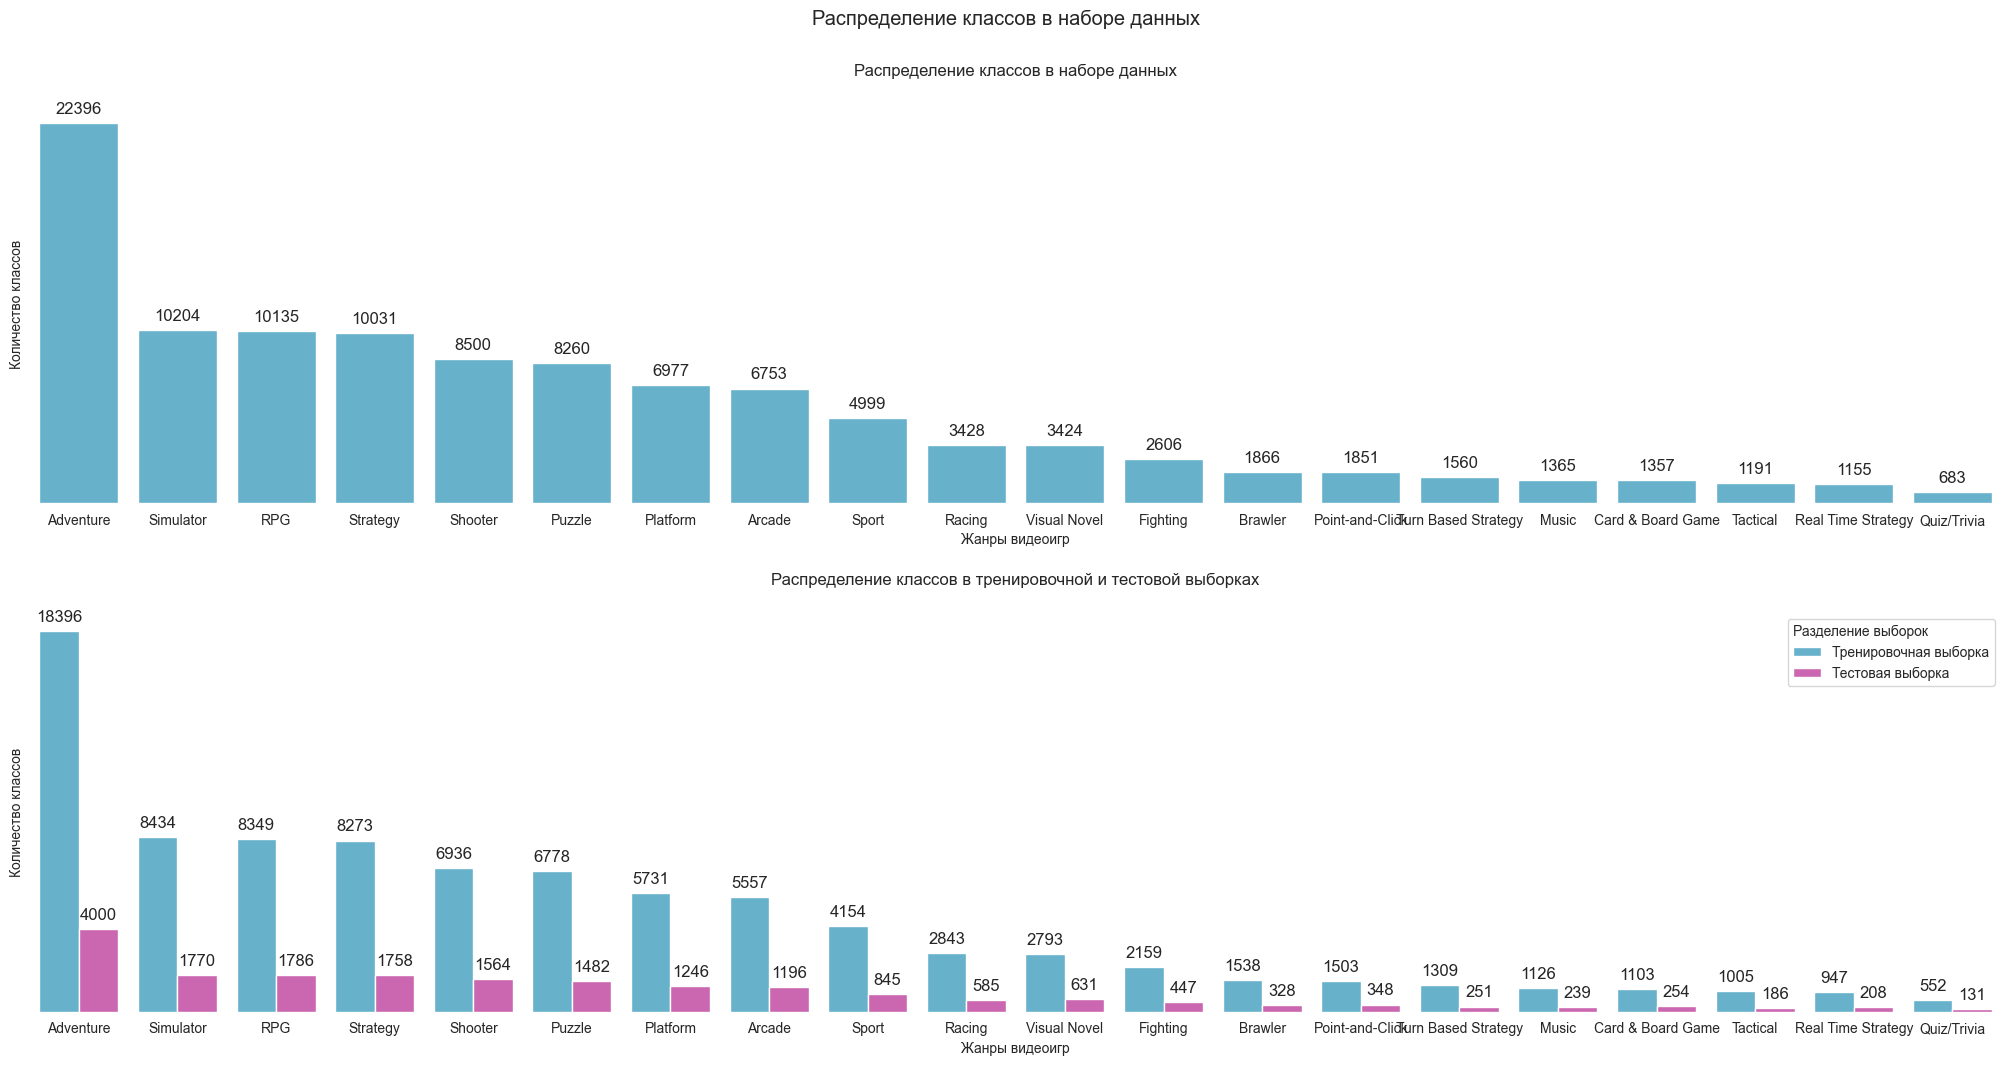

In [32]:
balance.balance(y_train, y_valid, labels)

В наборе данных **присутствует дисбаланс классов**. **Мажоритарным** классом является класс **Adventure** (количество экземпляров более **22 тыс.**). **Миноритарным** классом является класс **Quiz/Trivia** (количество экземпляров менее **1 тыс.**). **Остальные** классы имеют от **1000** до **10 тыс.** экземпляров.

## Предобработка текста
***

In [33]:
cleaner = FunctionTransformer(cleaning)
preprocessor = Pipeline(
    steps=[
        ('cleaner', cleaner)
    ]
)
preprocessor

Pipeline(steps=[('cleaner',
                 FunctionTransformer(func=<function cleaning at 0x000001FAC5113D90>))])

В ходе предобработки текста будут удалены все символы, отличные от симвволов **английского алфавита**.

## Частотный анализ

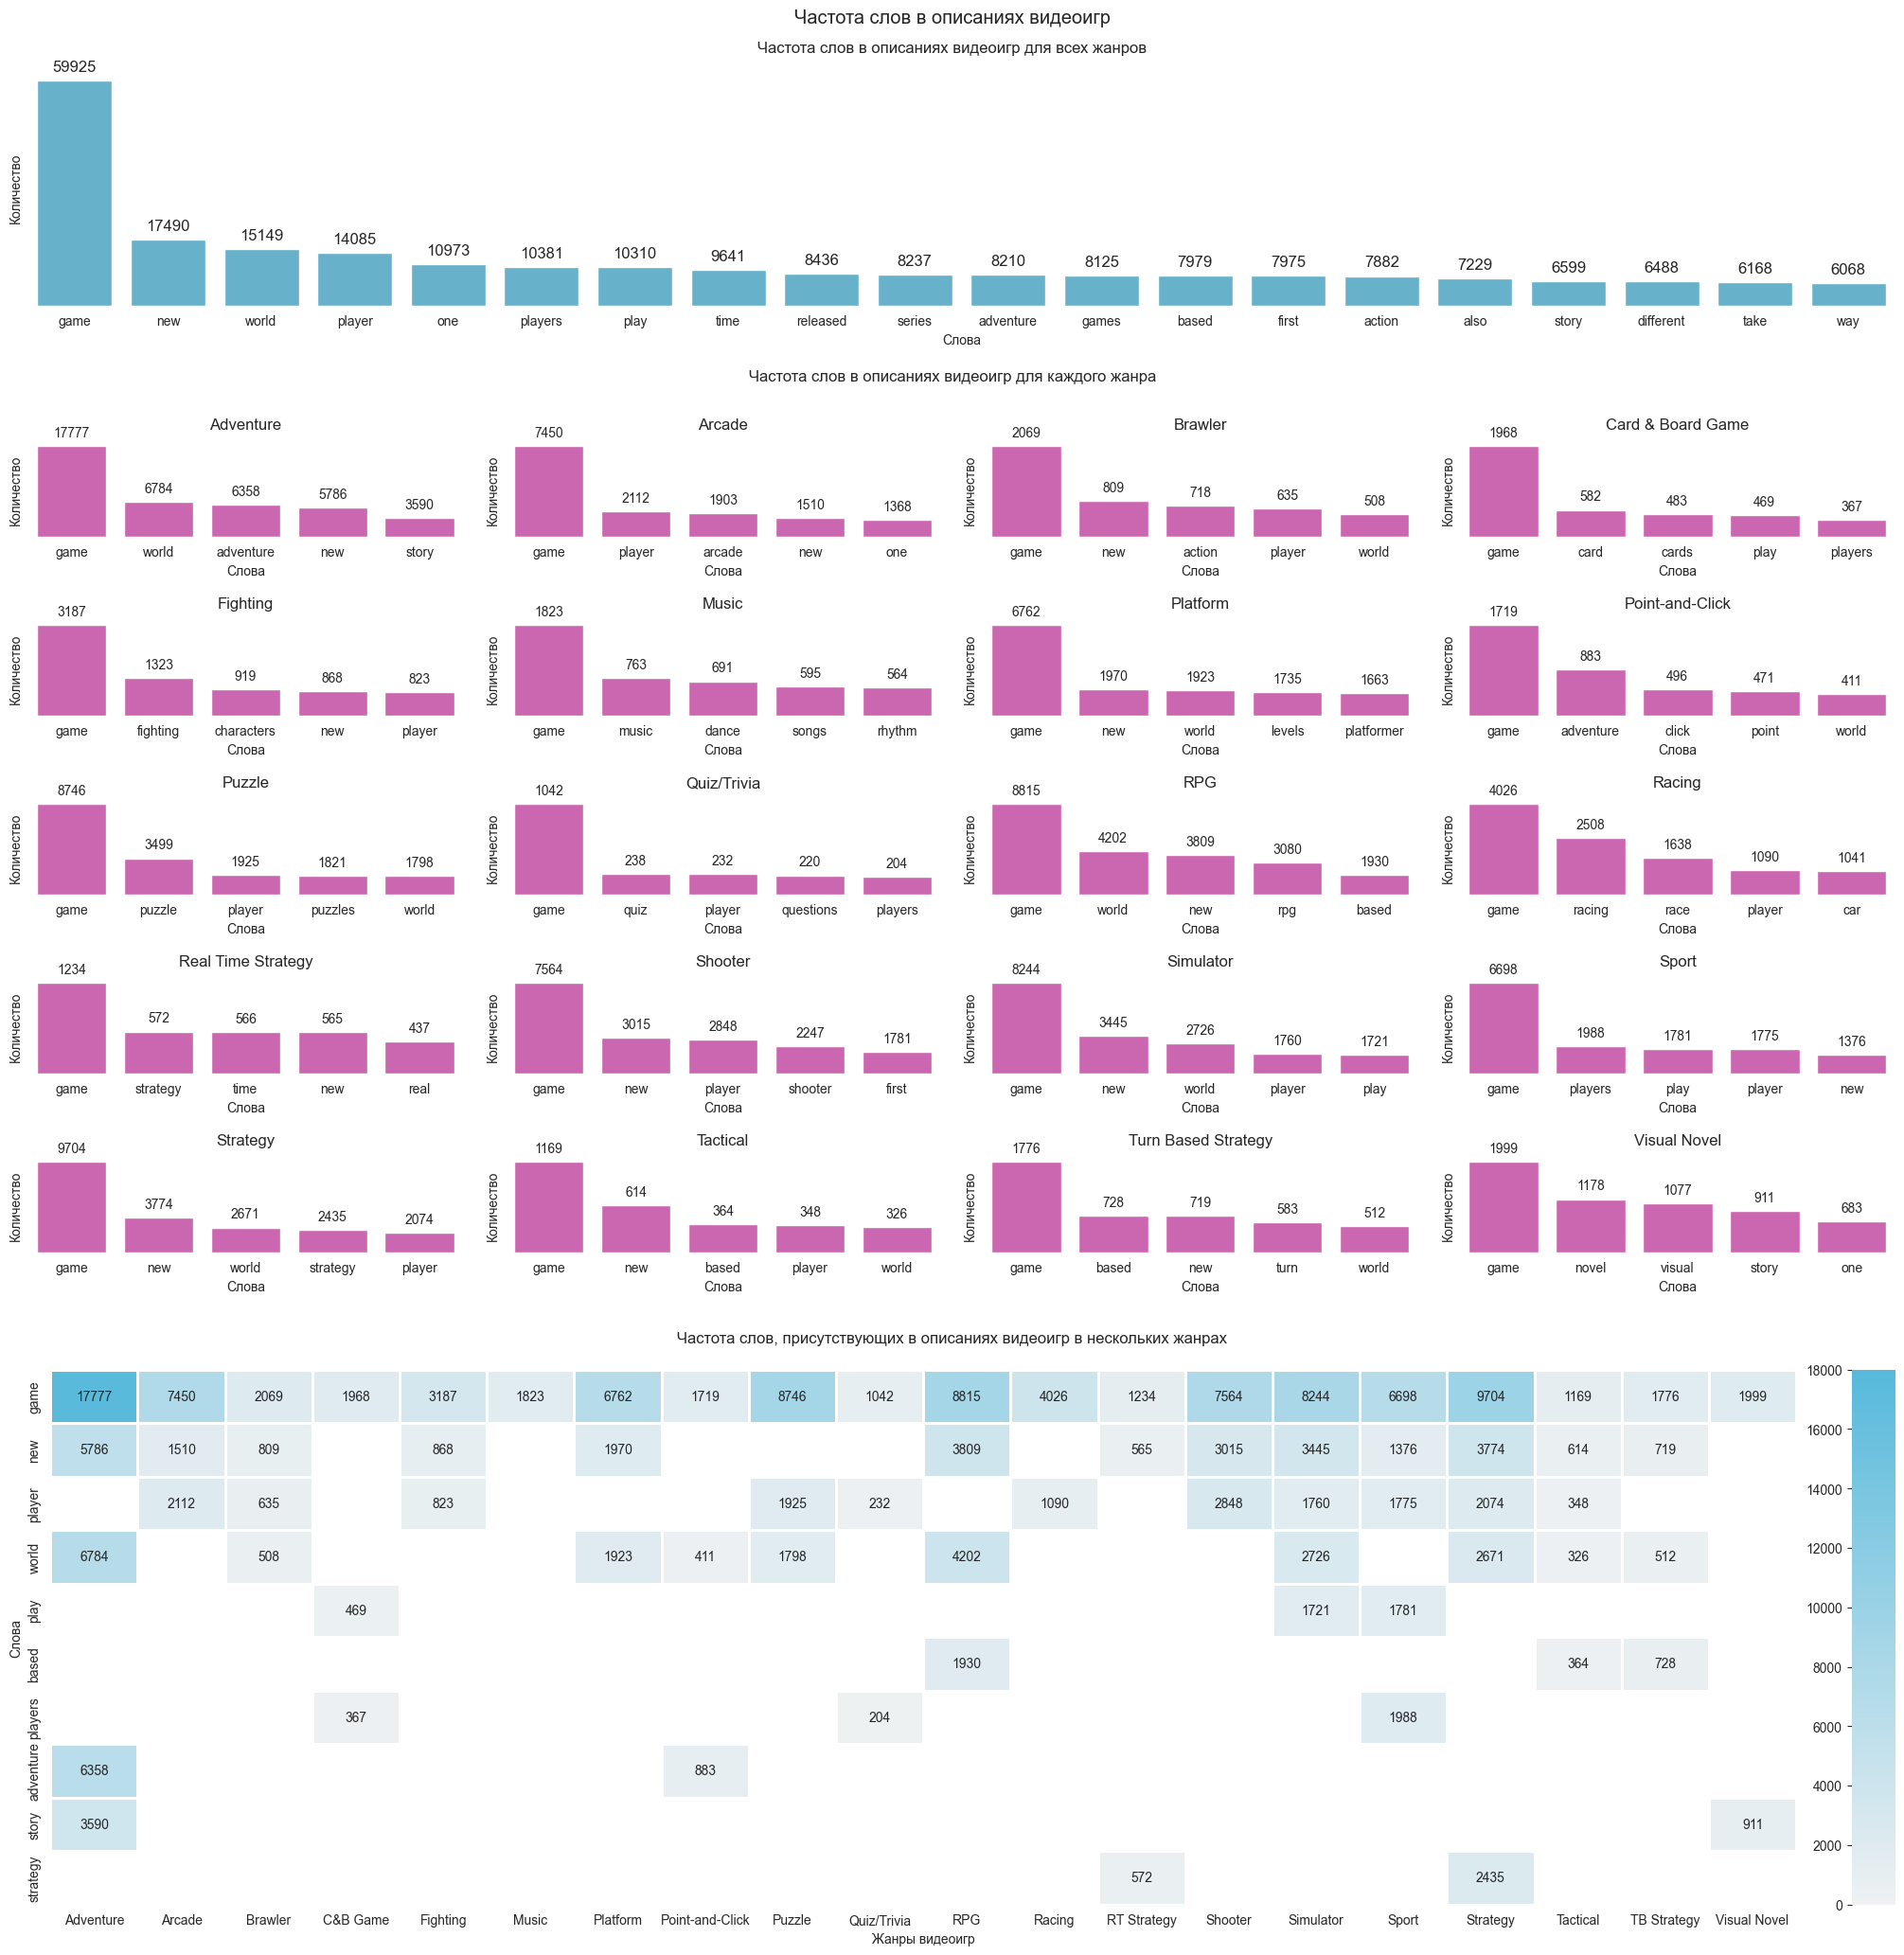

In [34]:
words.words(
    data=pd.concat([preprocessor.transform(x), y], axis=1),
    labels=labels,
    stop_words=stop_words
)

Наиболее часто в описаниях видеоигр встречается слово **game** (приблизительно **60 тыс.** раз). **Остальные слова** встречаются в описаниях видеоигр менее **17 тыс.** раз. Для каждого класса существует свой **уникальный** список наиболее часто встречающихся слов в описаниях видеоигр.

## Тестирование моделей
***

Для стандартизации признаков используем **TfidfVectorizer**.

In [35]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words=stop_words
)

standardizer = Pipeline(
    steps=[
        ('vectorizer', vectorizer)
    ]
)
standardizer

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]))])

Для оценки эффективности **предсказательной способности** модели, будем использовать метрику **f1-weighted**.

In [36]:
f1_weighted = make_scorer(
    score_func=f1_score,
    average='weighted',
    zero_division=0.0
)

В для оценки эффективности были выбраны следующие показатели:
- время обучения;
- время предсказания;
- f1-weighted.

In [37]:
columns = pd.MultiIndex.from_arrays(
    arrays=[
        ['Без сгенерированных признаков'] * 3 + ['Со сгенерированными признаками'] * 3,
        ['Время обучения', 'Время предсказания', 'f1-weighted'] * 2
        ], 
    names=('Признаки', 'Эффективность'))
index = ['ComplementNB', 'SGDClassifier']
results = pd.DataFrame(
    columns=columns,
    index=index
)
results.style.format(na_rep='-')

### Тестирование ComplementNB
***

In [38]:
estimator = ComplementNB()
estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)
    ]
)
pipeline

Pipeline(steps=[('standardizer',
                 Pipeline(steps=[('vectorizer',
                                  TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his', 'himself',
                                                              'she', "she's",
                                                              'her', 'hers',
                                                              'herself', 'it',
                                                              "it's", 'its',
                                                              'itself', ...]))])),
                ('estimator',
                 MultiOutputClassifier(estimator=ComplementNB(), n_jobs=4))])

In [39]:
param_grid = {
    'standardizer__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'standardizer__vectorizer__norm': [None, 'l1', 'l2'],
    'standardizer__vectorizer__sublinear_tf': [True, False],
    'standardizer__vectorizer__max_features': np.arange(
        start=500_000,
        stop=1_000_001,
        step=250_000
    ).tolist(),
    'estimator__estimator__norm': [False, True],
    'estimator__estimator__alpha': np.linspace(
        start=1.0,
        stop=10.0,
        num=10
    ).round(5).tolist()
}

In [40]:
best_param = {
    "estimator__estimator__alpha": [2.0],
    "estimator__estimator__norm": [False],
    "standardizer__vectorizer__max_features": [500000],
    "standardizer__vectorizer__ngram_range": [(1, 3)],
    "standardizer__vectorizer__norm": [None],
    "standardizer__vectorizer__sublinear_tf": [False]
}

In [41]:
%%time
complement_nb = GridSearchCV(
    estimator=pipeline, 
    param_grid=best_param, 
    scoring=f1_weighted,
    error_score=0.0,
    cv=3, 
    verbose=3,
    refit=True
)
complement_nb.fit(preprocessor.transform(x_train)['description'], y_train); 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.585 total time=  19.7s
[CV 2/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.589 total time=  18.9s
[CV 3/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.584 total time=  18.9s
CPU times: total: 1min 12s
Wall time: 1min 20s


In [42]:
cv_results = pd.DataFrame(
    data=complement_nb.cv_results_, 
).sort_values('rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__estimator__alpha,param_estimator__estimator__norm,param_standardizer__vectorizer__max_features,param_standardizer__vectorizer__ngram_range,param_standardizer__vectorizer__norm,param_standardizer__vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,14.760757,0.742014,4.506176,0.371428,2.0,False,500000,"(1, 3)",None,False,"{'estimator__estimator__alpha': 2.0, 'estimato...",0.585461,0.588808,0.584017,0.586095,0.002007,1


In [43]:
results.loc['ComplementNB', ('Без сгенерированных признаков', 'Время обучения')] = cv_results.loc[0, 'mean_fit_time']
results.loc['ComplementNB', ('Без сгенерированных признаков', 'Время предсказания')] = cv_results.loc[0, 'mean_score_time']
results.loc['ComplementNB', ('Без сгенерированных признаков', 'f1-weighted')] = cv_results.loc[0, 'mean_test_score']

In [44]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=complement_nb.best_estimator_,
    X=preprocessor.transform(x_train)['description'],
    y=y_train,
    train_sizes=LEARNING_CURVE_SPLITTING_STRATEGY_TRAIN_SIZES,
    cv=ShuffleSplit(
        n_splits=LEARNING_CURVE_SPLITTING_STRATEGY_N_SPLITS,
        test_size=LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE,
        random_state=RANDOM_STATE
    ),
    n_jobs=N_JOBS,
    scoring=f1_weighted,
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  409  2046  8184 16369 24554 32739 40924]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:   52.5s remaining:  1.7min
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:  1.7min remaining:   47.7s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  2.7min finished


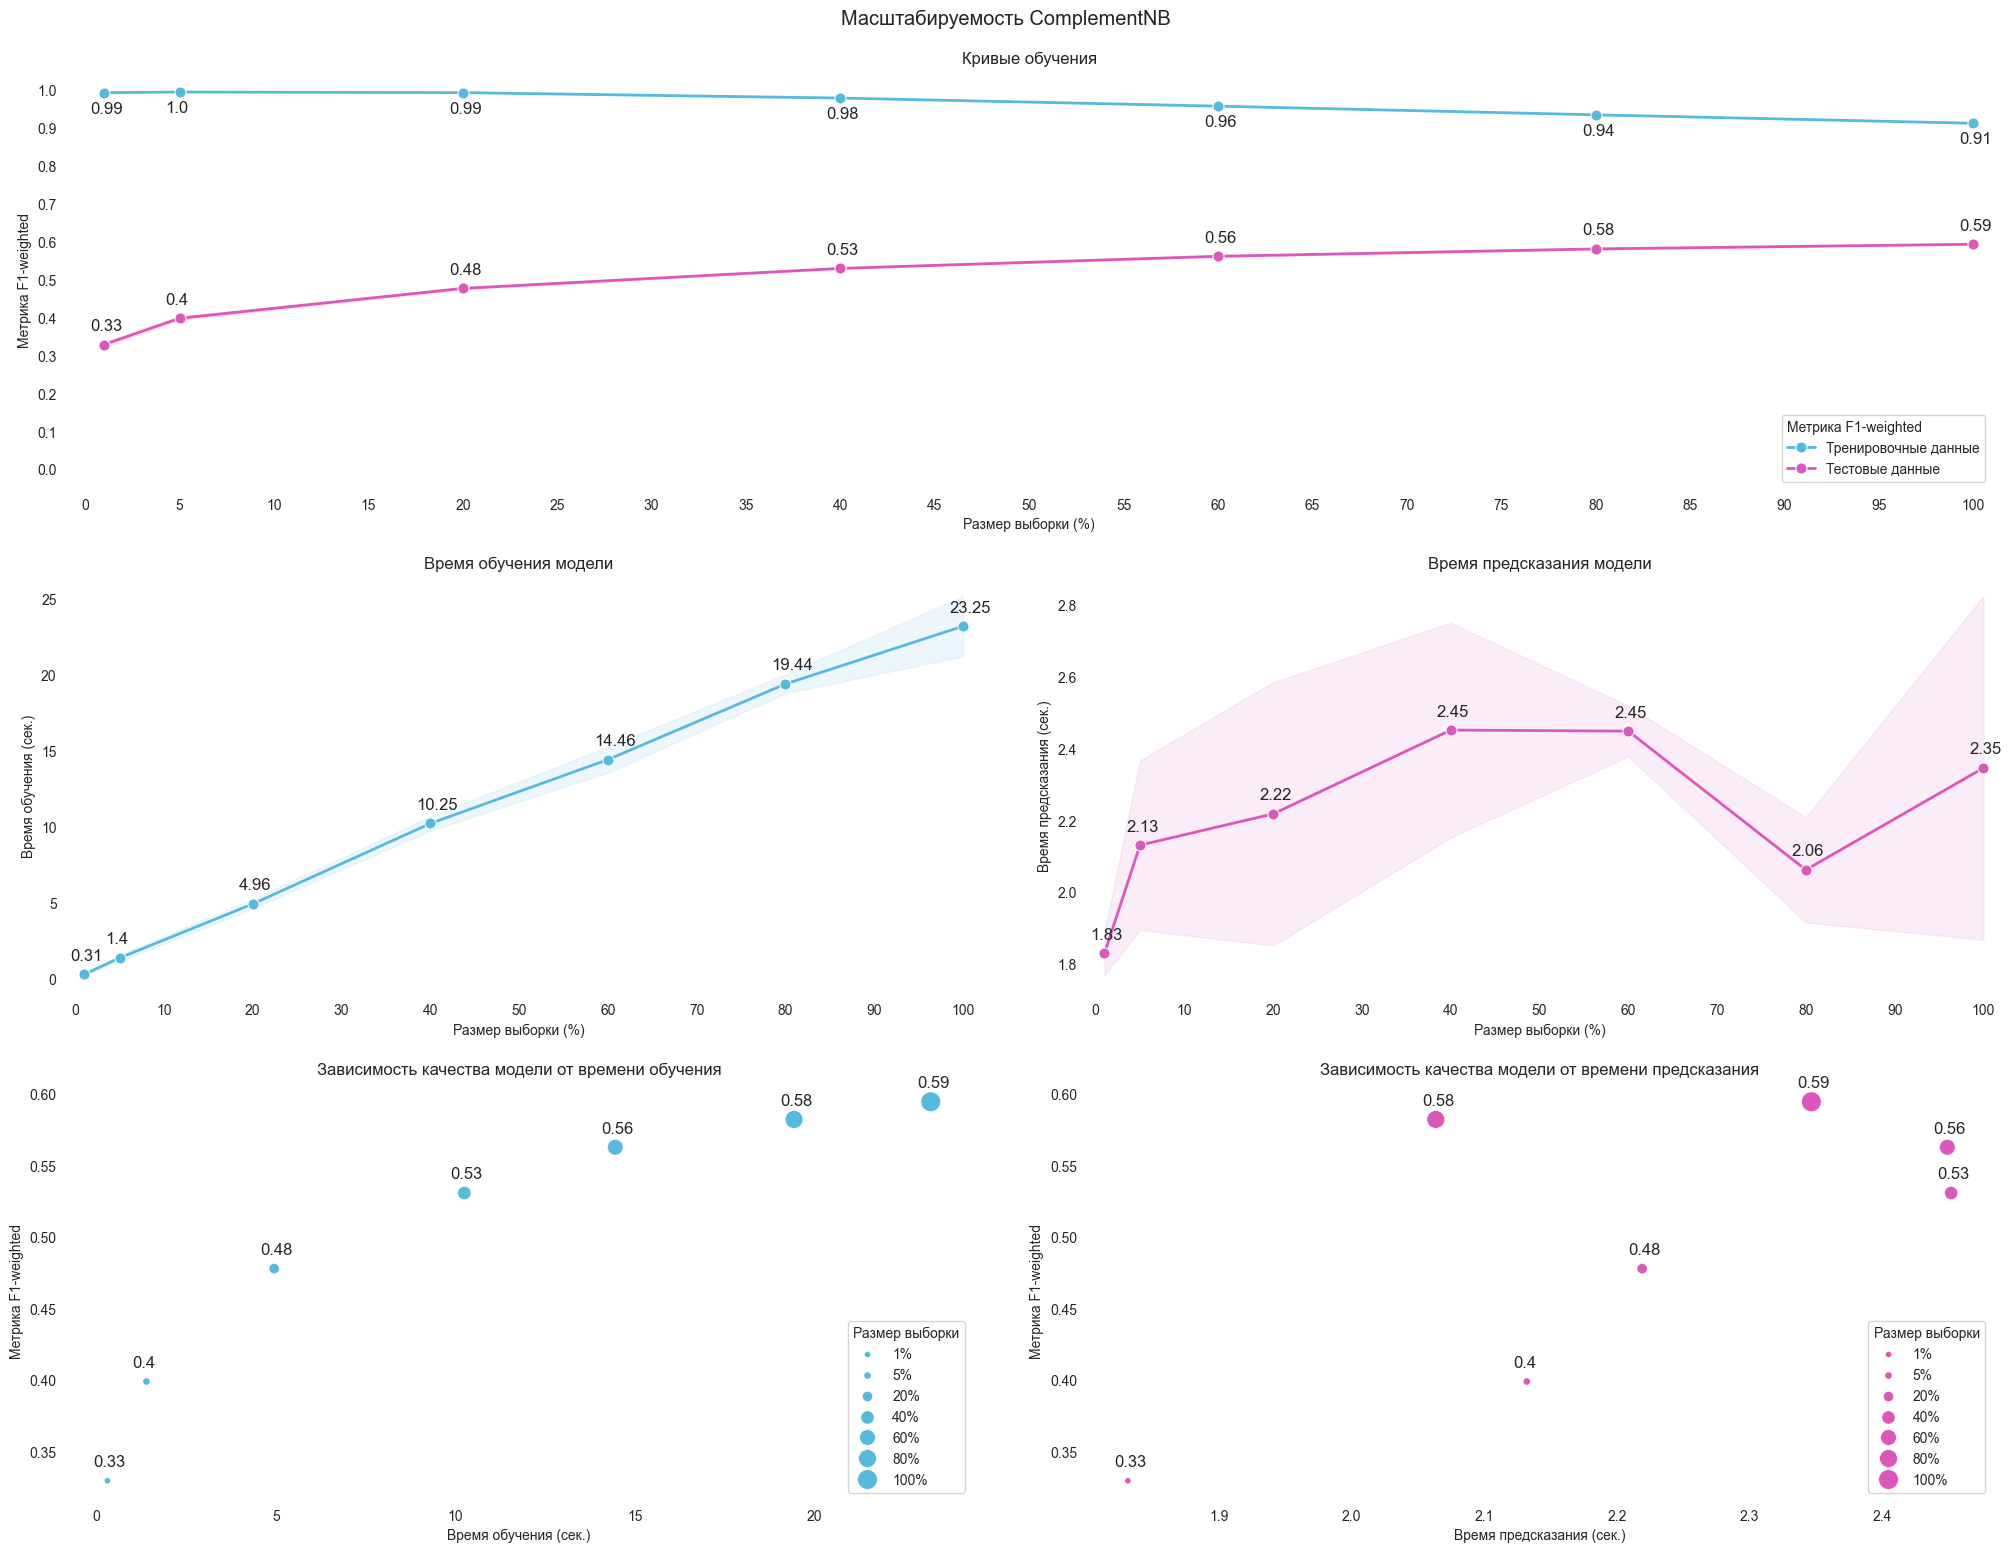

In [45]:
x_train_size = x_train.shape[0]
x_train_size *= (1 - LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE)
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость ComplementNB',
)

Кривые обучения показывают, что **присутствует** признак переобучения модели. **Добавление новых данных** возможно **улучшит** предсказательную способность модели. При добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.

In [46]:
predict = complement_nb.predict(preprocessor.transform(x_valid)['description'])
predict_proba = complement_nb.predict_proba(preprocessor.transform(x_valid)['description'])

In [47]:
f1 = f1_score(
    y_true=y_valid,
    y_pred=predict,
    average='weighted'
)

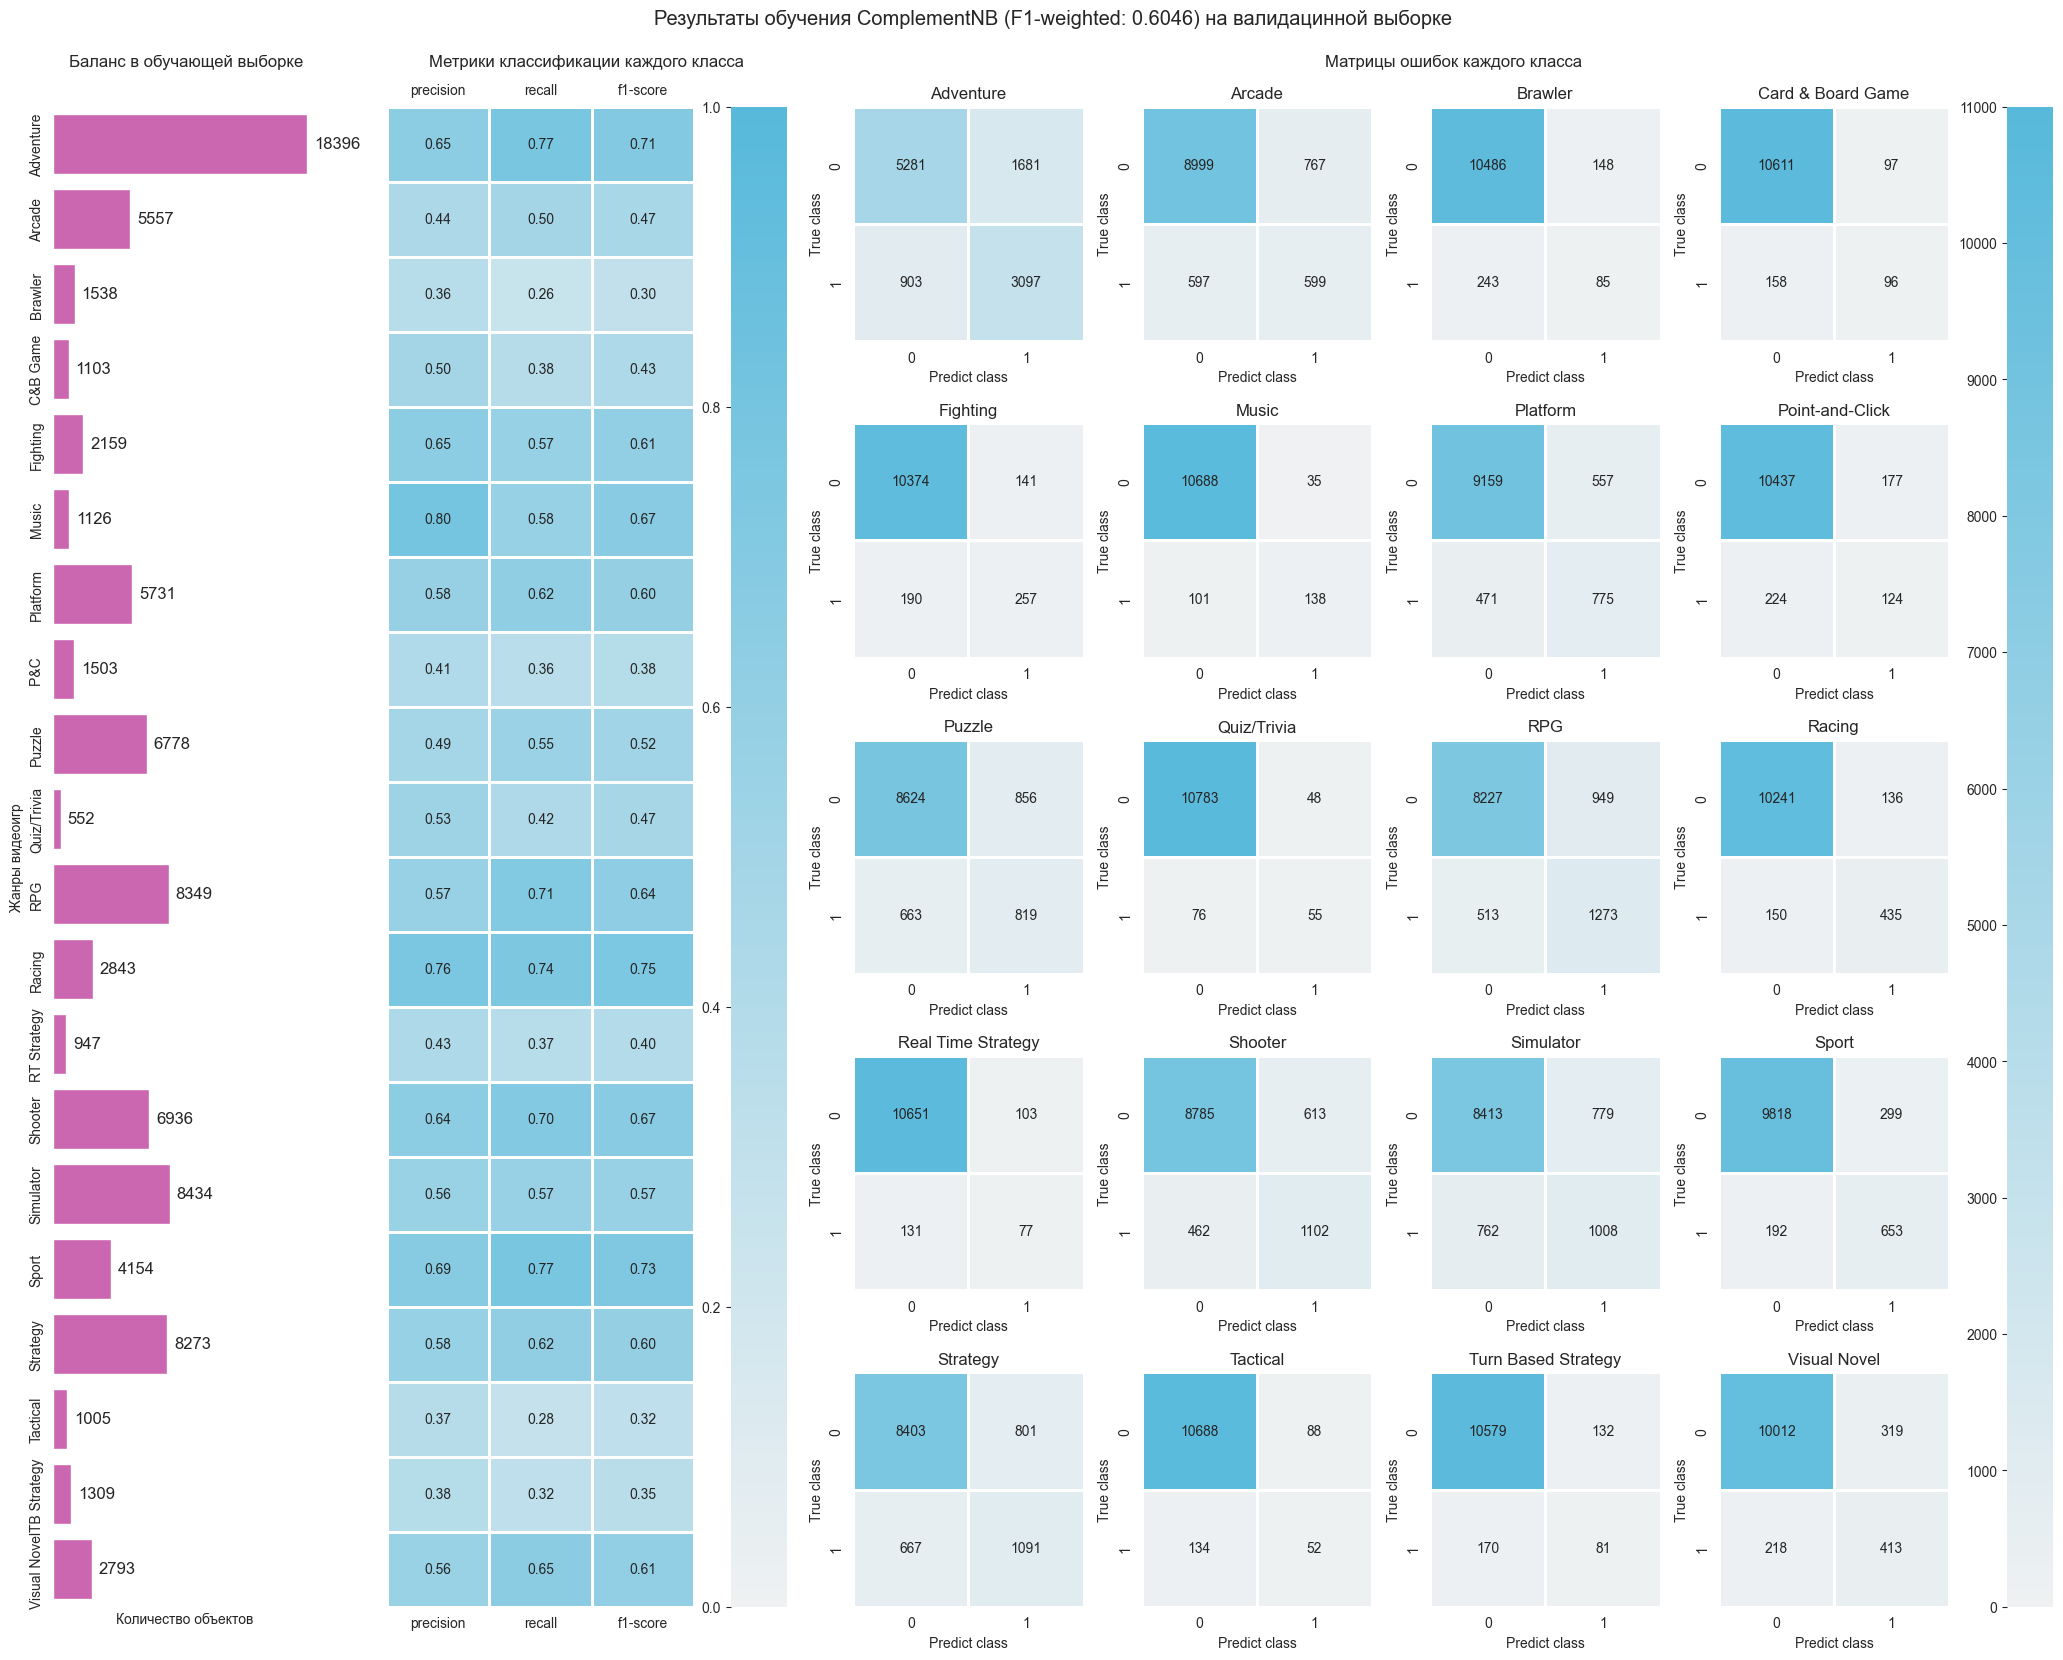

In [48]:
metrics.metrics(
    y_test=y_valid,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения ComplementNB '
          f'(F1-weighted: {f1:.4f}) на валидацинной выборке',
    labels=labels
)

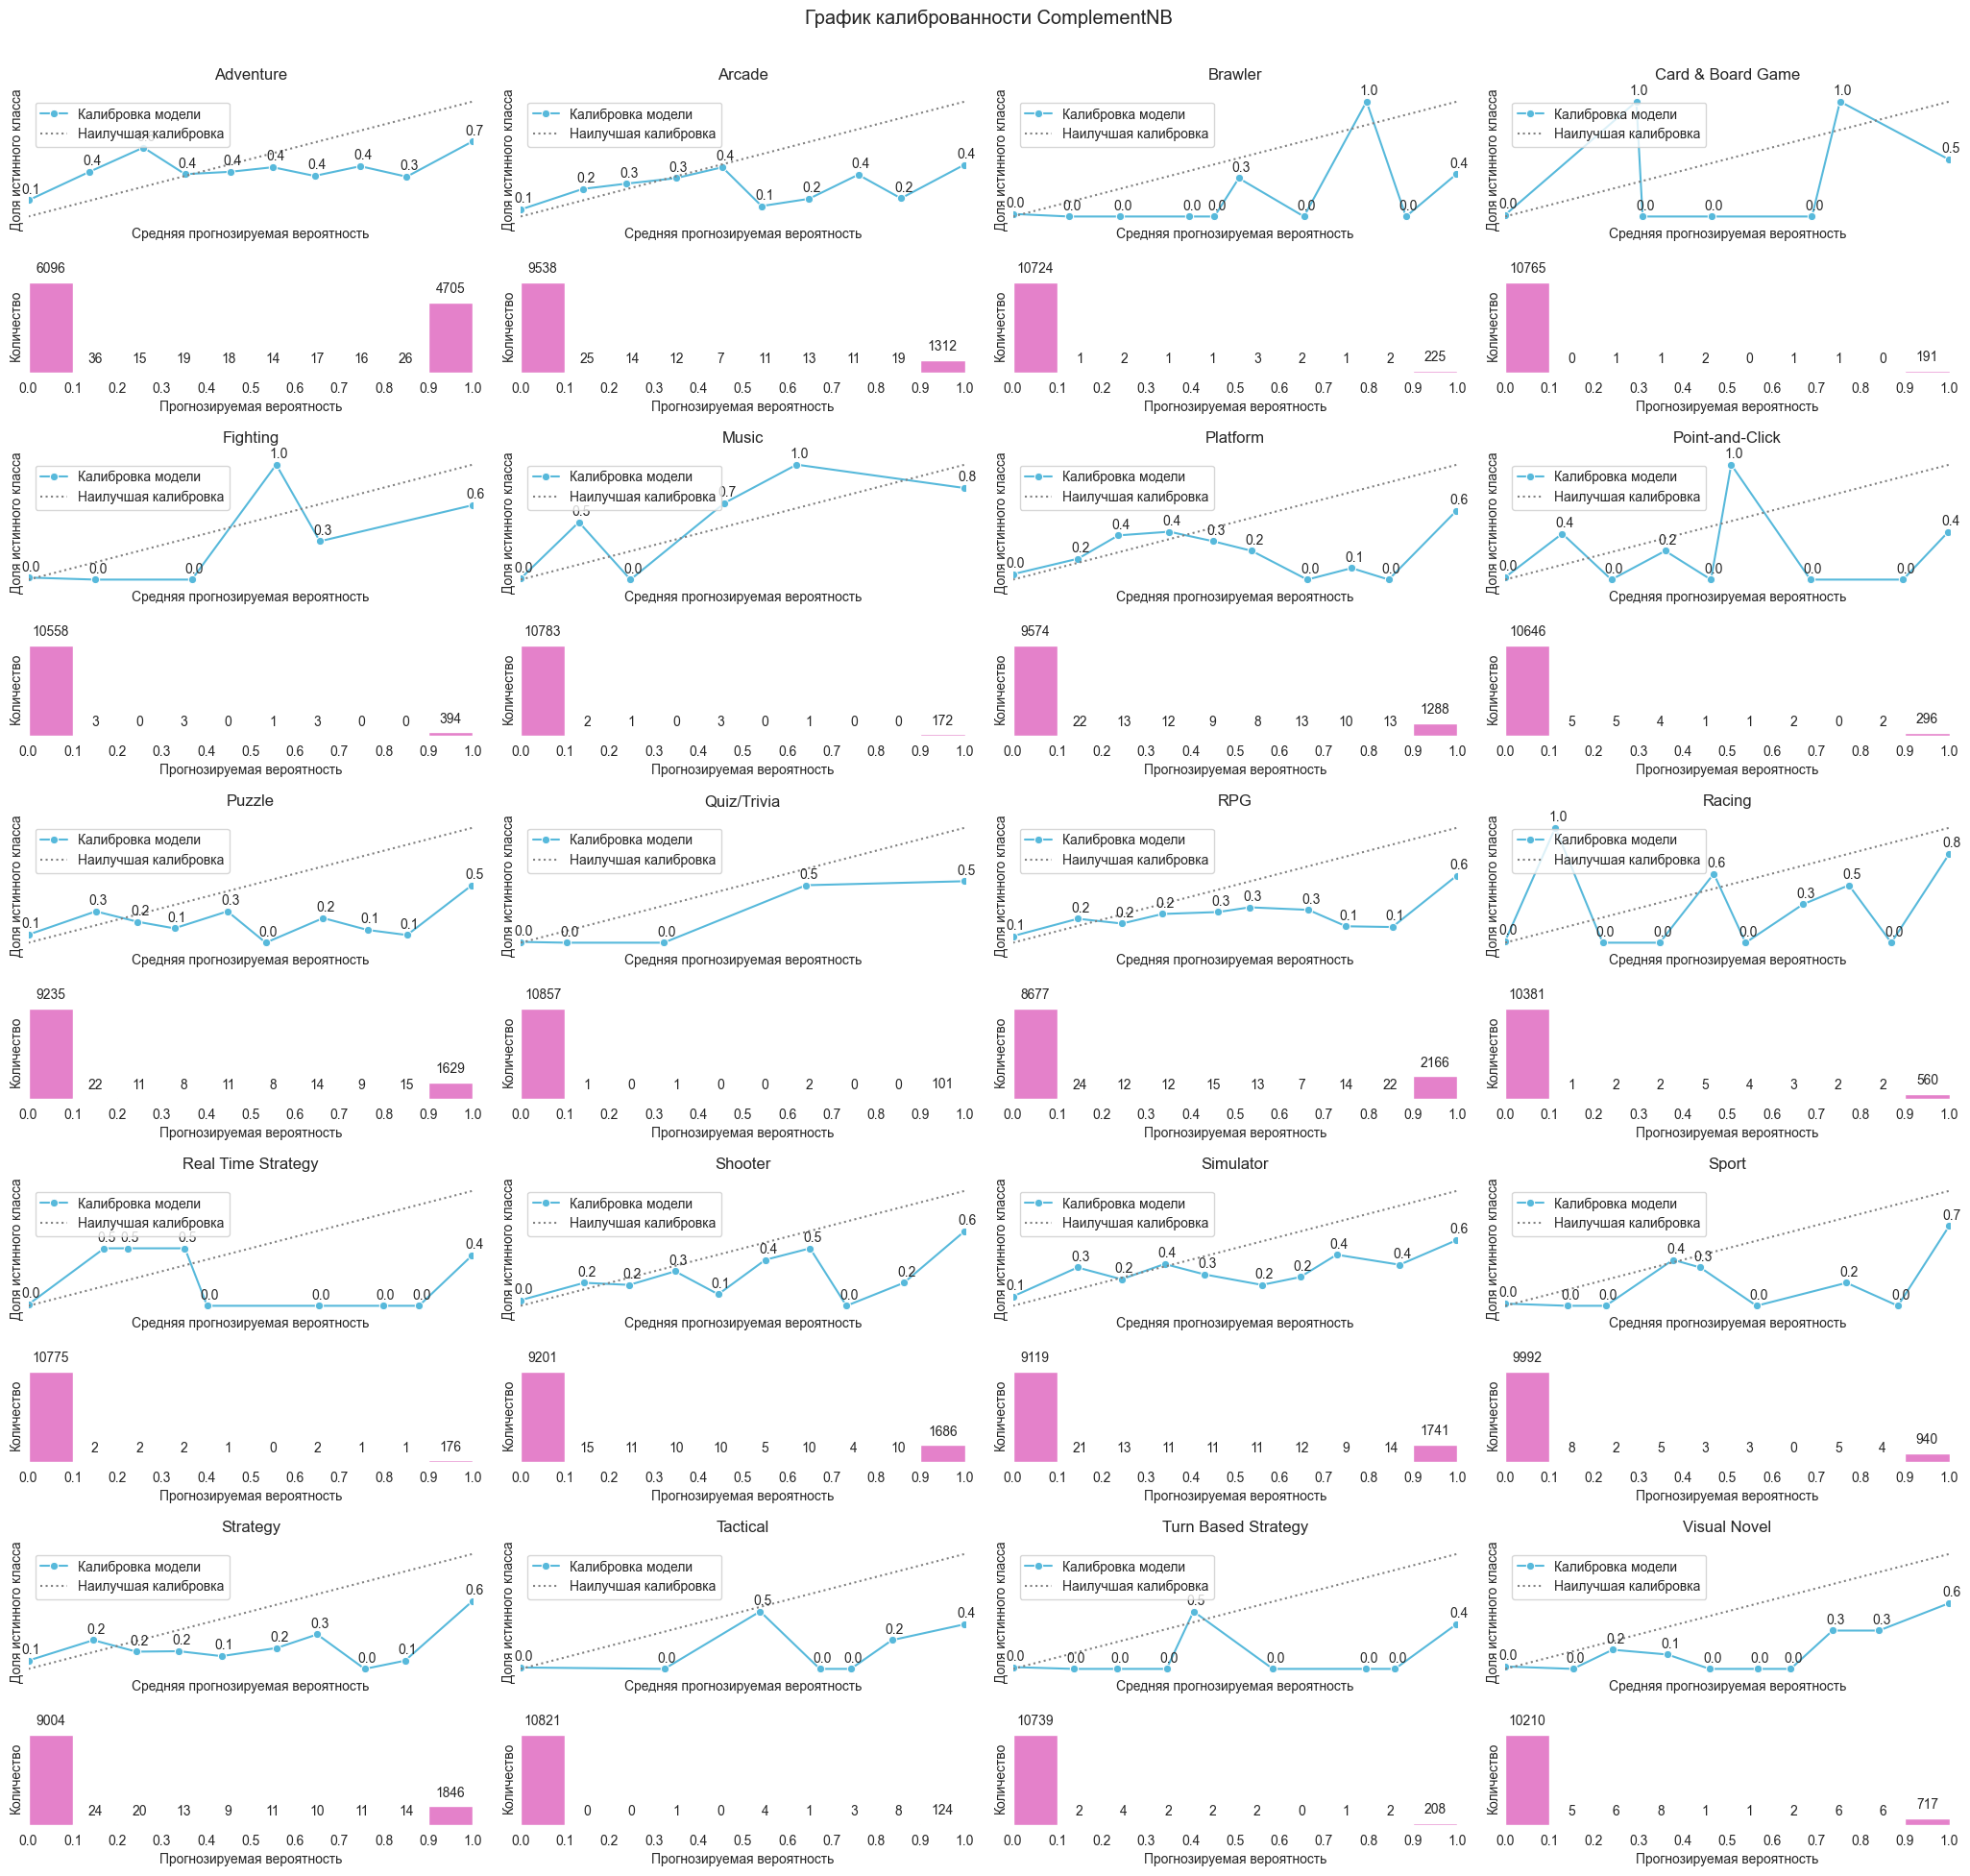

In [49]:
calibration.calibration(
    y_true=y_valid,
    y_proba=[pd.DataFrame(x) for x in predict_proba], 
    labels=labels, 
    title='График калиброванности ComplementNB'
)

Модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу. Прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**. Вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми. **Необходима** калибровка модели. 

### Тестирование SGDClassifier
***

In [50]:
estimator = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    random_state=42
)

estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)
    ]
)
pipeline

Pipeline(steps=[('standardizer',
                 Pipeline(steps=[('vectorizer',
                                  TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his', 'himself',
                                                              'she', "she's",
                                                              'her', 'hers',
                                                              'herself', 'it',
                                                              "it's", 'its',
                                                              'itself', ...]))])),
                ('estimator',
                 MultiOutputClassifier(estimator=SGDClassifier(loss='log_loss',
                                                               penalty='elasticnet',
                                                               random_state=42),
                                       n_jobs=4))])

In [51]:
param_grid = {
    'standardizer__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'standardizer__vectorizer__norm': [None, 'l1', 'l2'],
    'standardizer__vectorizer__sublinear_tf': [True],
    'standardizer__vectorizer__max_features': np.arange(
        start=750_000,
        stop=1_000_001,
        step=250_000
    ).tolist(),
    'estimator__estimator__alpha': np.linspace(
        start=0.1,
        stop=0.5,
        num=5
    ).round(5).tolist(),
    'estimator__estimator__class_weight': [None, 'balanced'],
    'estimator__estimator__l1_ratio': np.linspace(
        start=0.0,
        stop=0.5,
        num=6
    ).round(5).tolist()
}

In [52]:
best_param = {
    "estimator__estimator__alpha": [0.1],
    "estimator__estimator__class_weight": ["balanced"],
    "estimator__estimator__l1_ratio": [0.0],
    "standardizer__vectorizer__max_features": [1000000],
    "standardizer__vectorizer__ngram_range": [(1, 3)],
    'standardizer__vectorizer__sublinear_tf': [True],
    "standardizer__vectorizer__norm": [None]
}

In [53]:
%%time
sgd = GridSearchCV(
    estimator=pipeline, 
    param_grid=best_param, 
    scoring=f1_weighted,
    error_score=0.0,
    cv=3, 
    verbose=3,
    refit=True
)
sgd.fit(preprocessor.transform(x_train)['description'], y_train); 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=True;, score=0.611 total time=  22.9s
[CV 2/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=True;, score=0.612 total time=  22.6s
[CV 3/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer_

In [54]:
cv_results = pd.DataFrame(
    data=sgd.cv_results_, 
).sort_values('rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__estimator__alpha,param_estimator__estimator__class_weight,param_estimator__estimator__l1_ratio,param_standardizer__vectorizer__max_features,param_standardizer__vectorizer__ngram_range,param_standardizer__vectorizer__norm,param_standardizer__vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,19.889714,0.149856,2.936691,0.109293,0.1,balanced,0.0,1000000,"(1, 3)",None,True,"{'estimator__estimator__alpha': 0.1, 'estimato...",0.611251,0.61164,0.609751,0.610881,0.000814,1


In [55]:
results.loc['SGDClassifier', ('Без сгенерированных признаков', 'Время обучения')] = cv_results.loc[0, 'mean_fit_time']
results.loc['SGDClassifier', ('Без сгенерированных признаков', 'Время предсказания')] = cv_results.loc[0, 'mean_score_time']
results.loc['SGDClassifier', ('Без сгенерированных признаков', 'f1-weighted')] = cv_results.loc[0, 'mean_test_score']

In [56]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=sgd.best_estimator_,
    X=preprocessor.transform(x_train)['description'],
    y=y_train,
    train_sizes=LEARNING_CURVE_SPLITTING_STRATEGY_TRAIN_SIZES,
    cv=ShuffleSplit(
        n_splits=LEARNING_CURVE_SPLITTING_STRATEGY_N_SPLITS,
        test_size=LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE,
        random_state=RANDOM_STATE
    ),
    n_jobs=N_JOBS,
    scoring=f1_weighted,
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  409  2046  8184 16369 24554 32739 40924]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:  1.3min remaining:  2.4min
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:  2.8min remaining:  1.3min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  4.3min finished


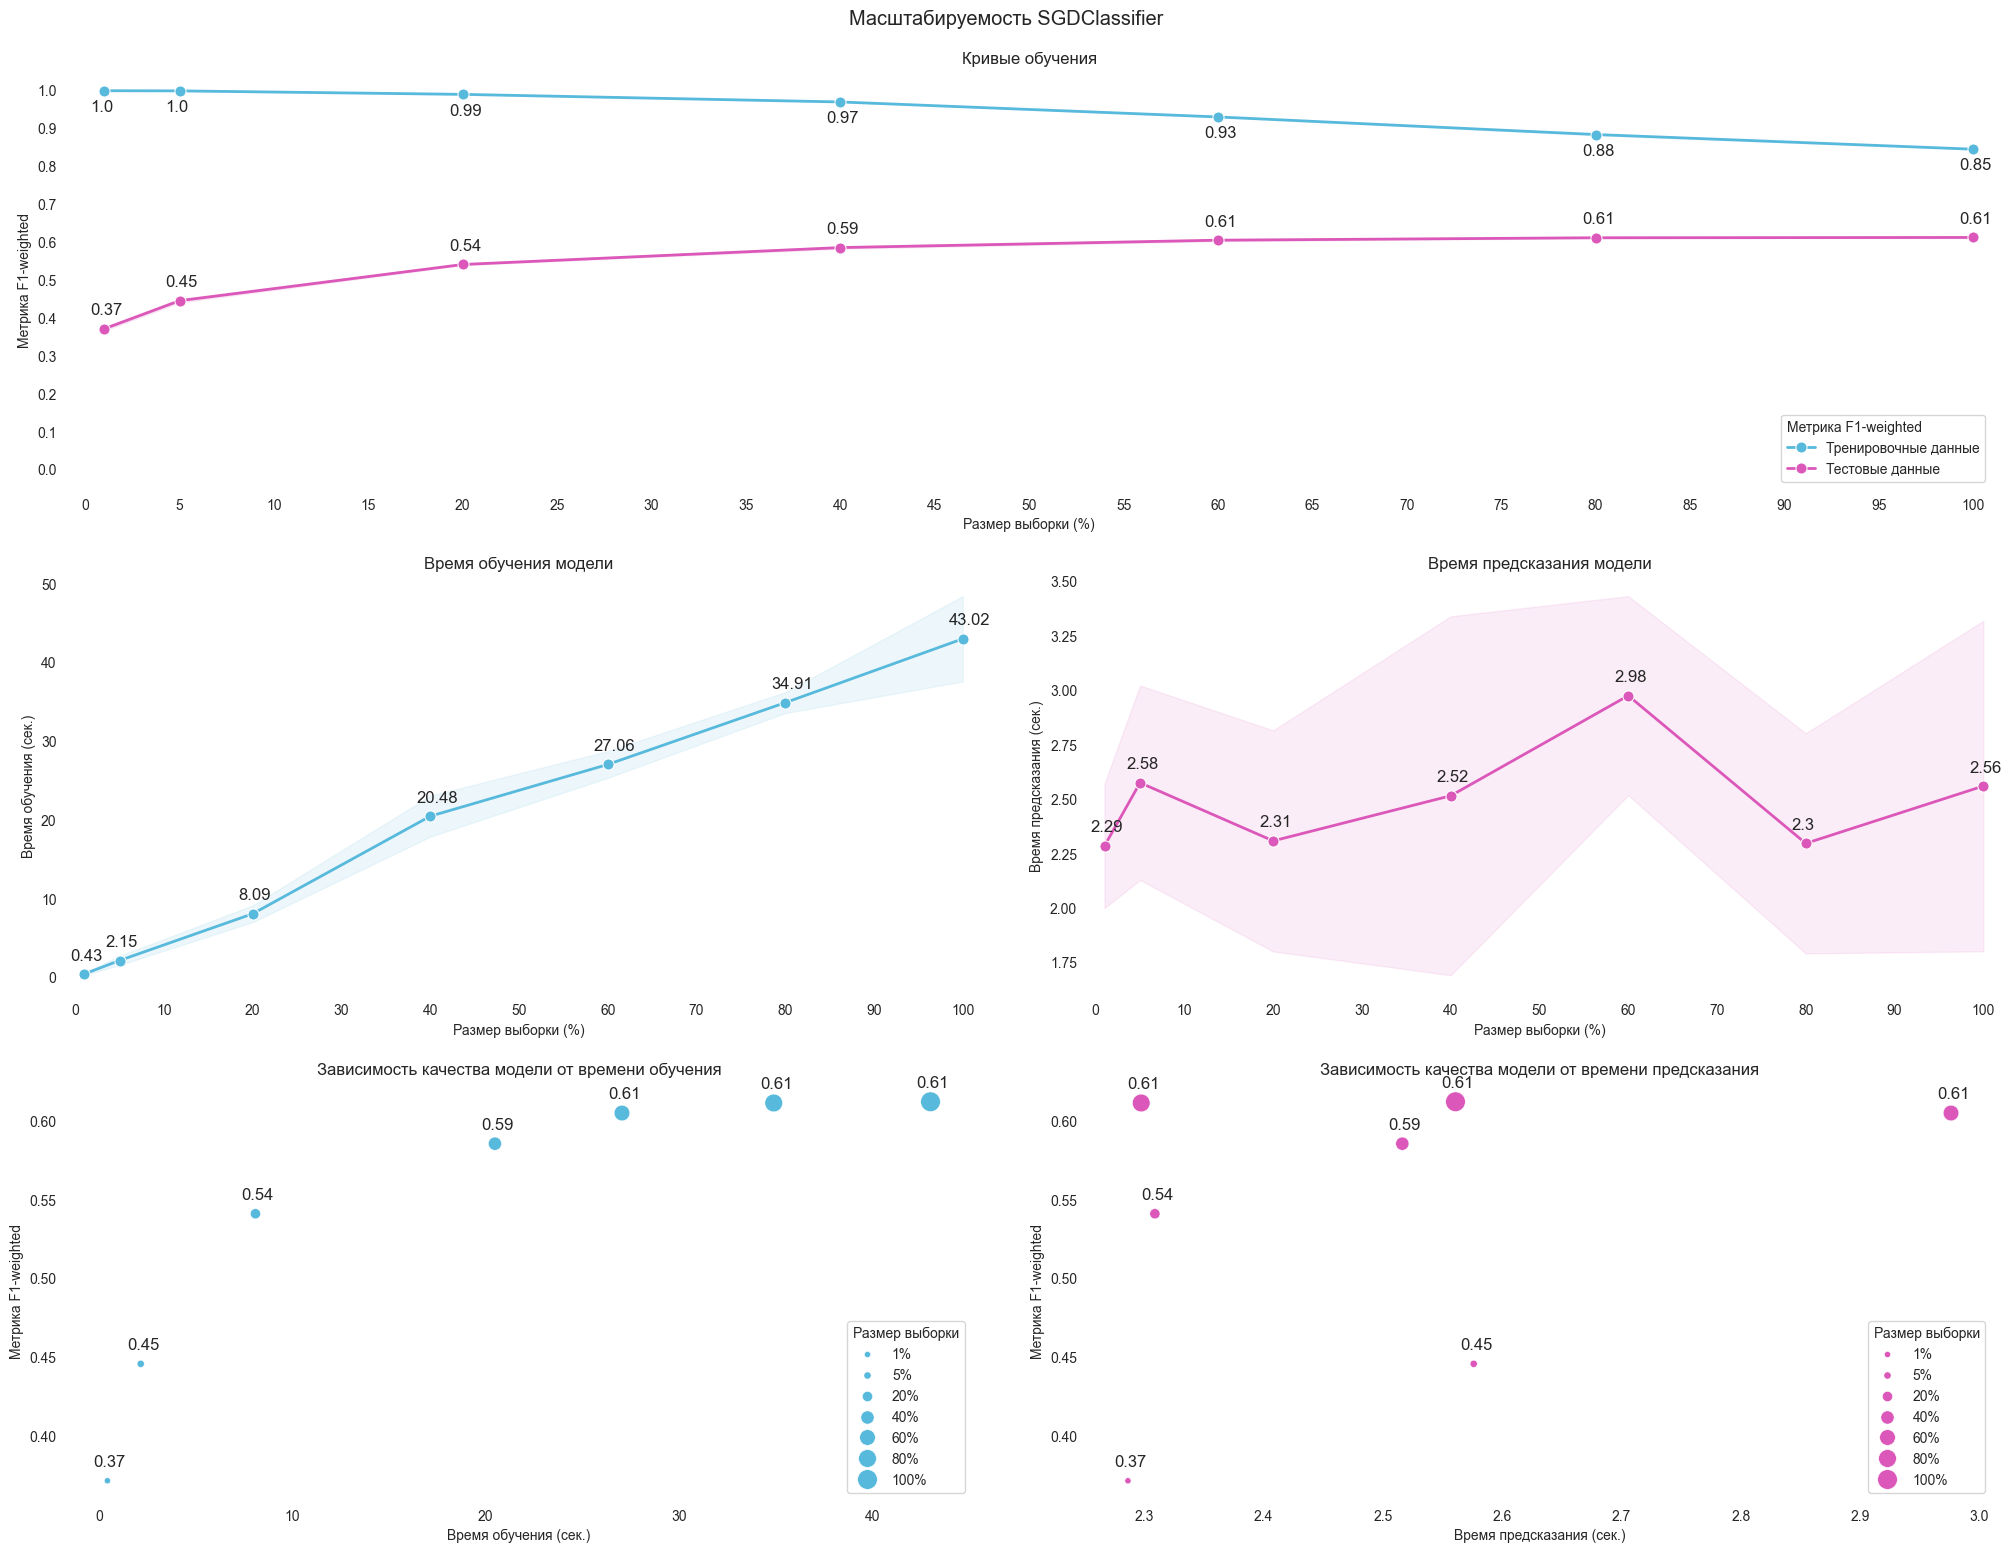

In [57]:
x_train_size = x_train.shape[0]
x_train_size *= (1 - LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE)
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость SGDClassifier',
)

Кривые обучения показывают, что **присутствует** признак переобучения модели. **Добавление новых данных не улучшит** предсказательную способность модели. При добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.

In [58]:
predict = sgd.predict(preprocessor.transform(x_valid)['description'])
predict_proba = sgd.predict_proba(preprocessor.transform(x_valid)['description'])

In [59]:
f1 = f1_score(
    y_true=y_valid,
    y_pred=predict,
    average='weighted'
)

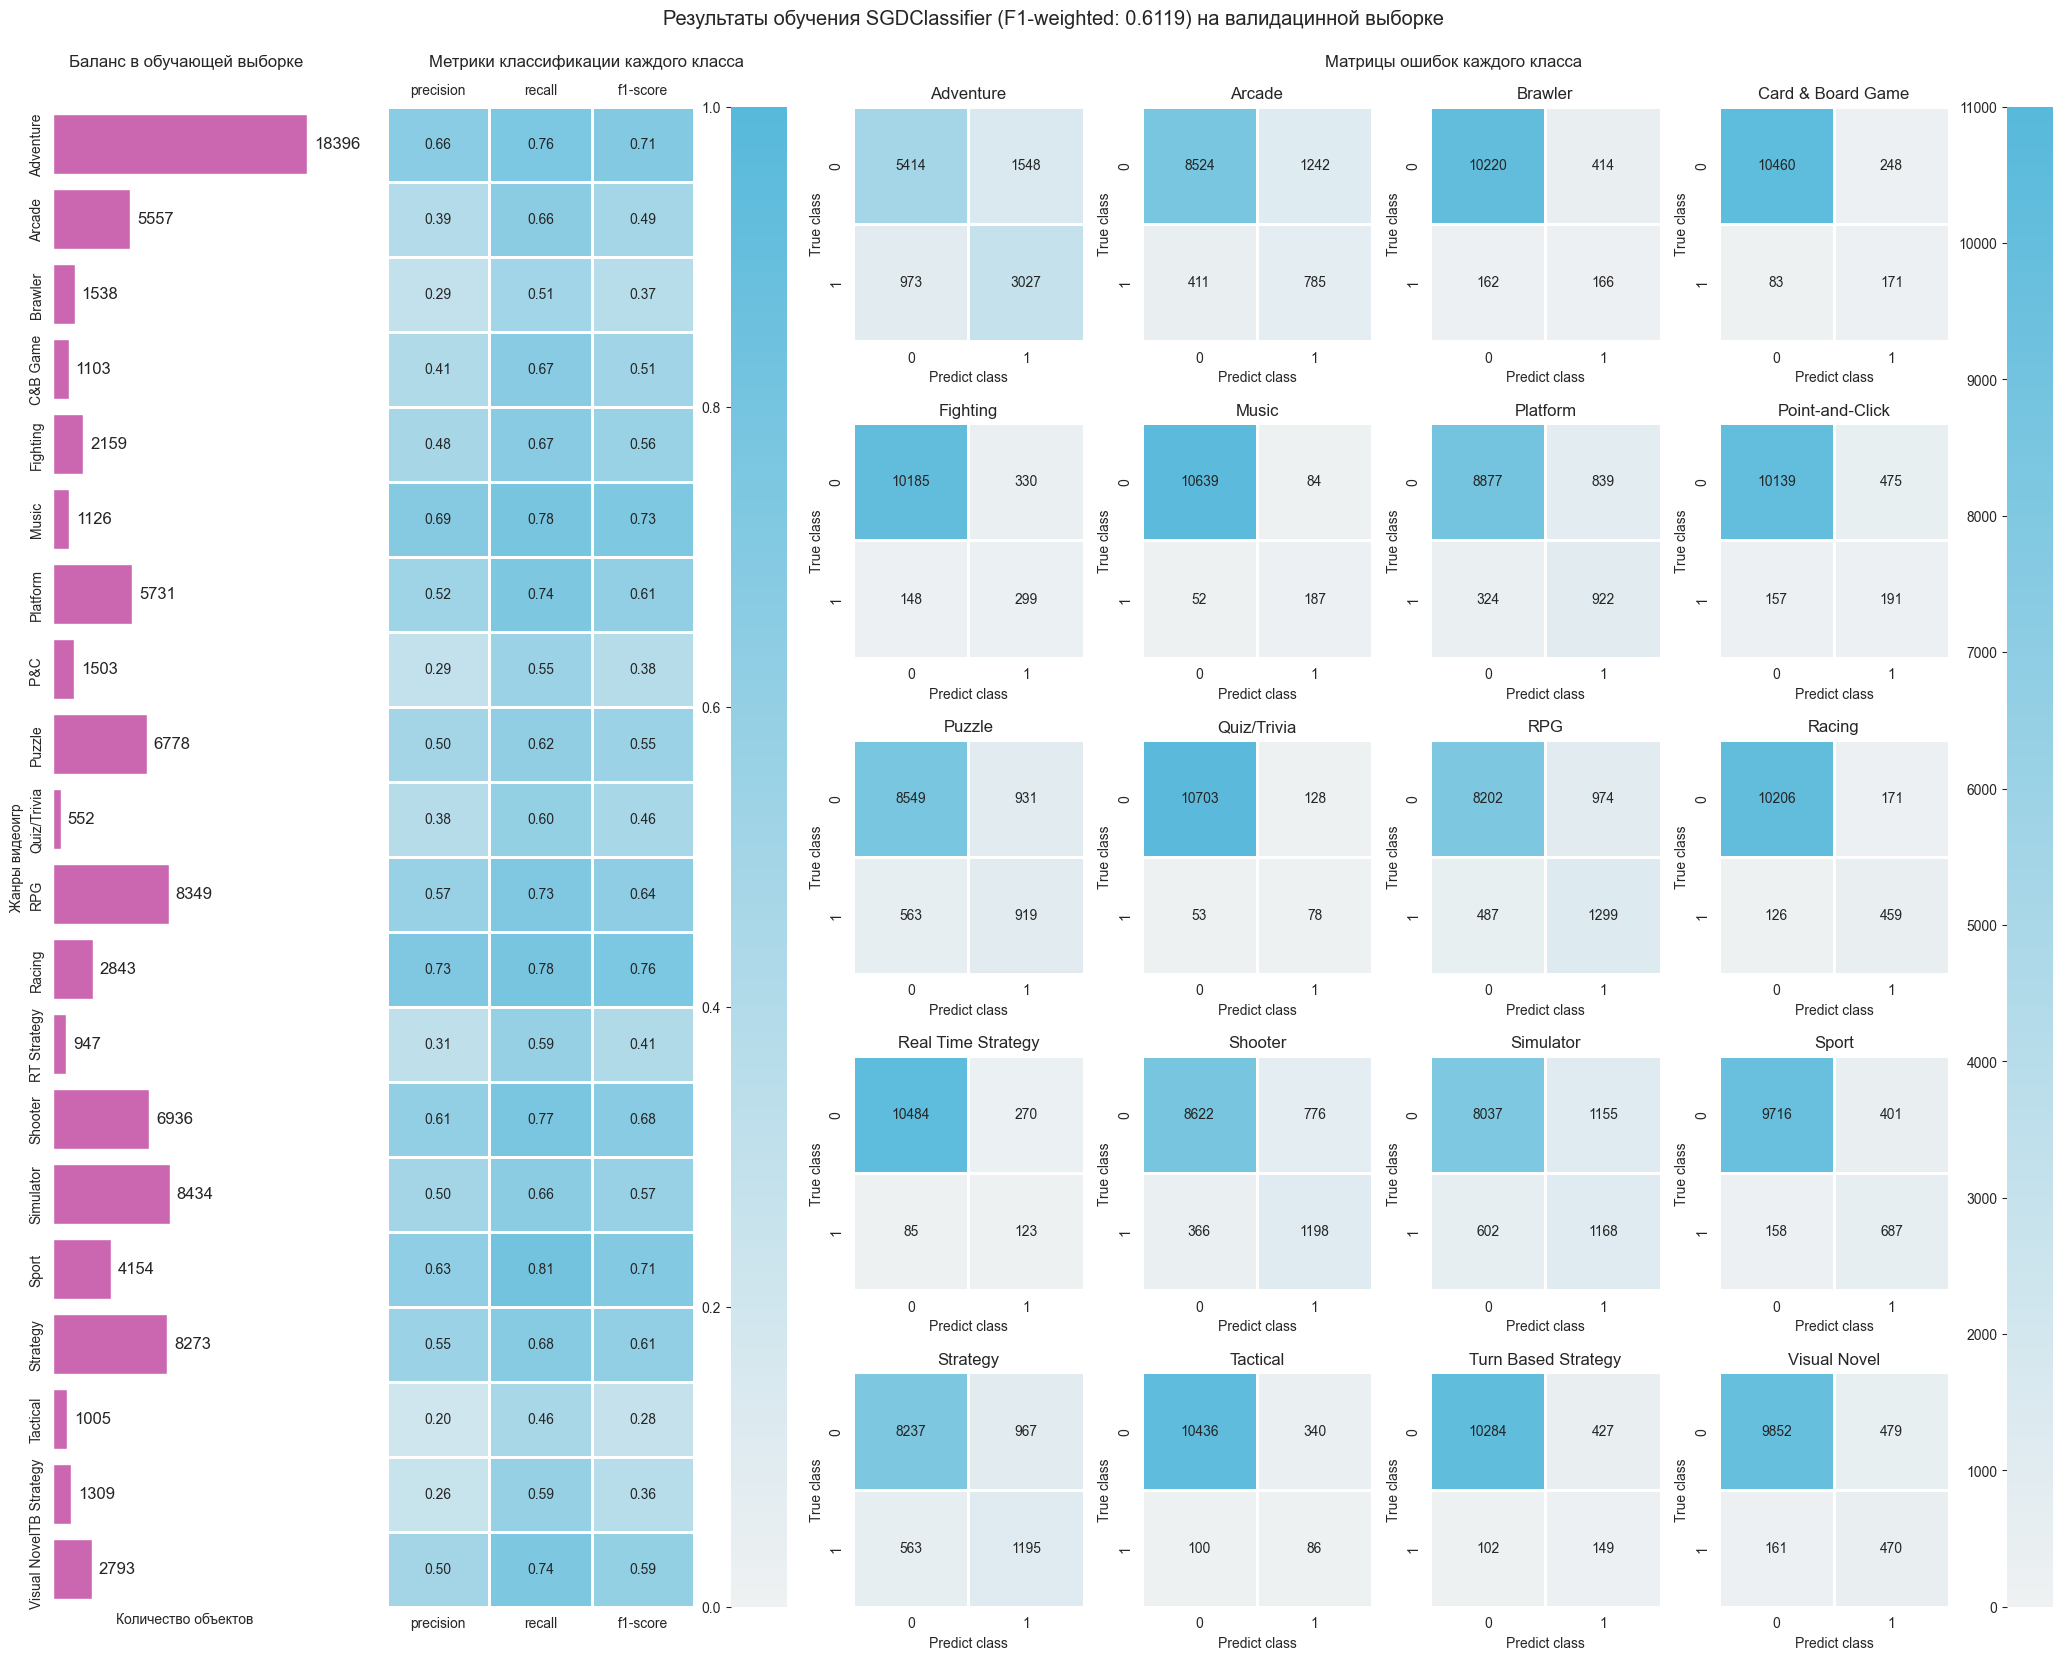

In [60]:
metrics.metrics(
    y_test=y_valid,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения SGDClassifier '
          f'(F1-weighted: {f1:.4f}) на валидацинной выборке',
    labels=labels
)

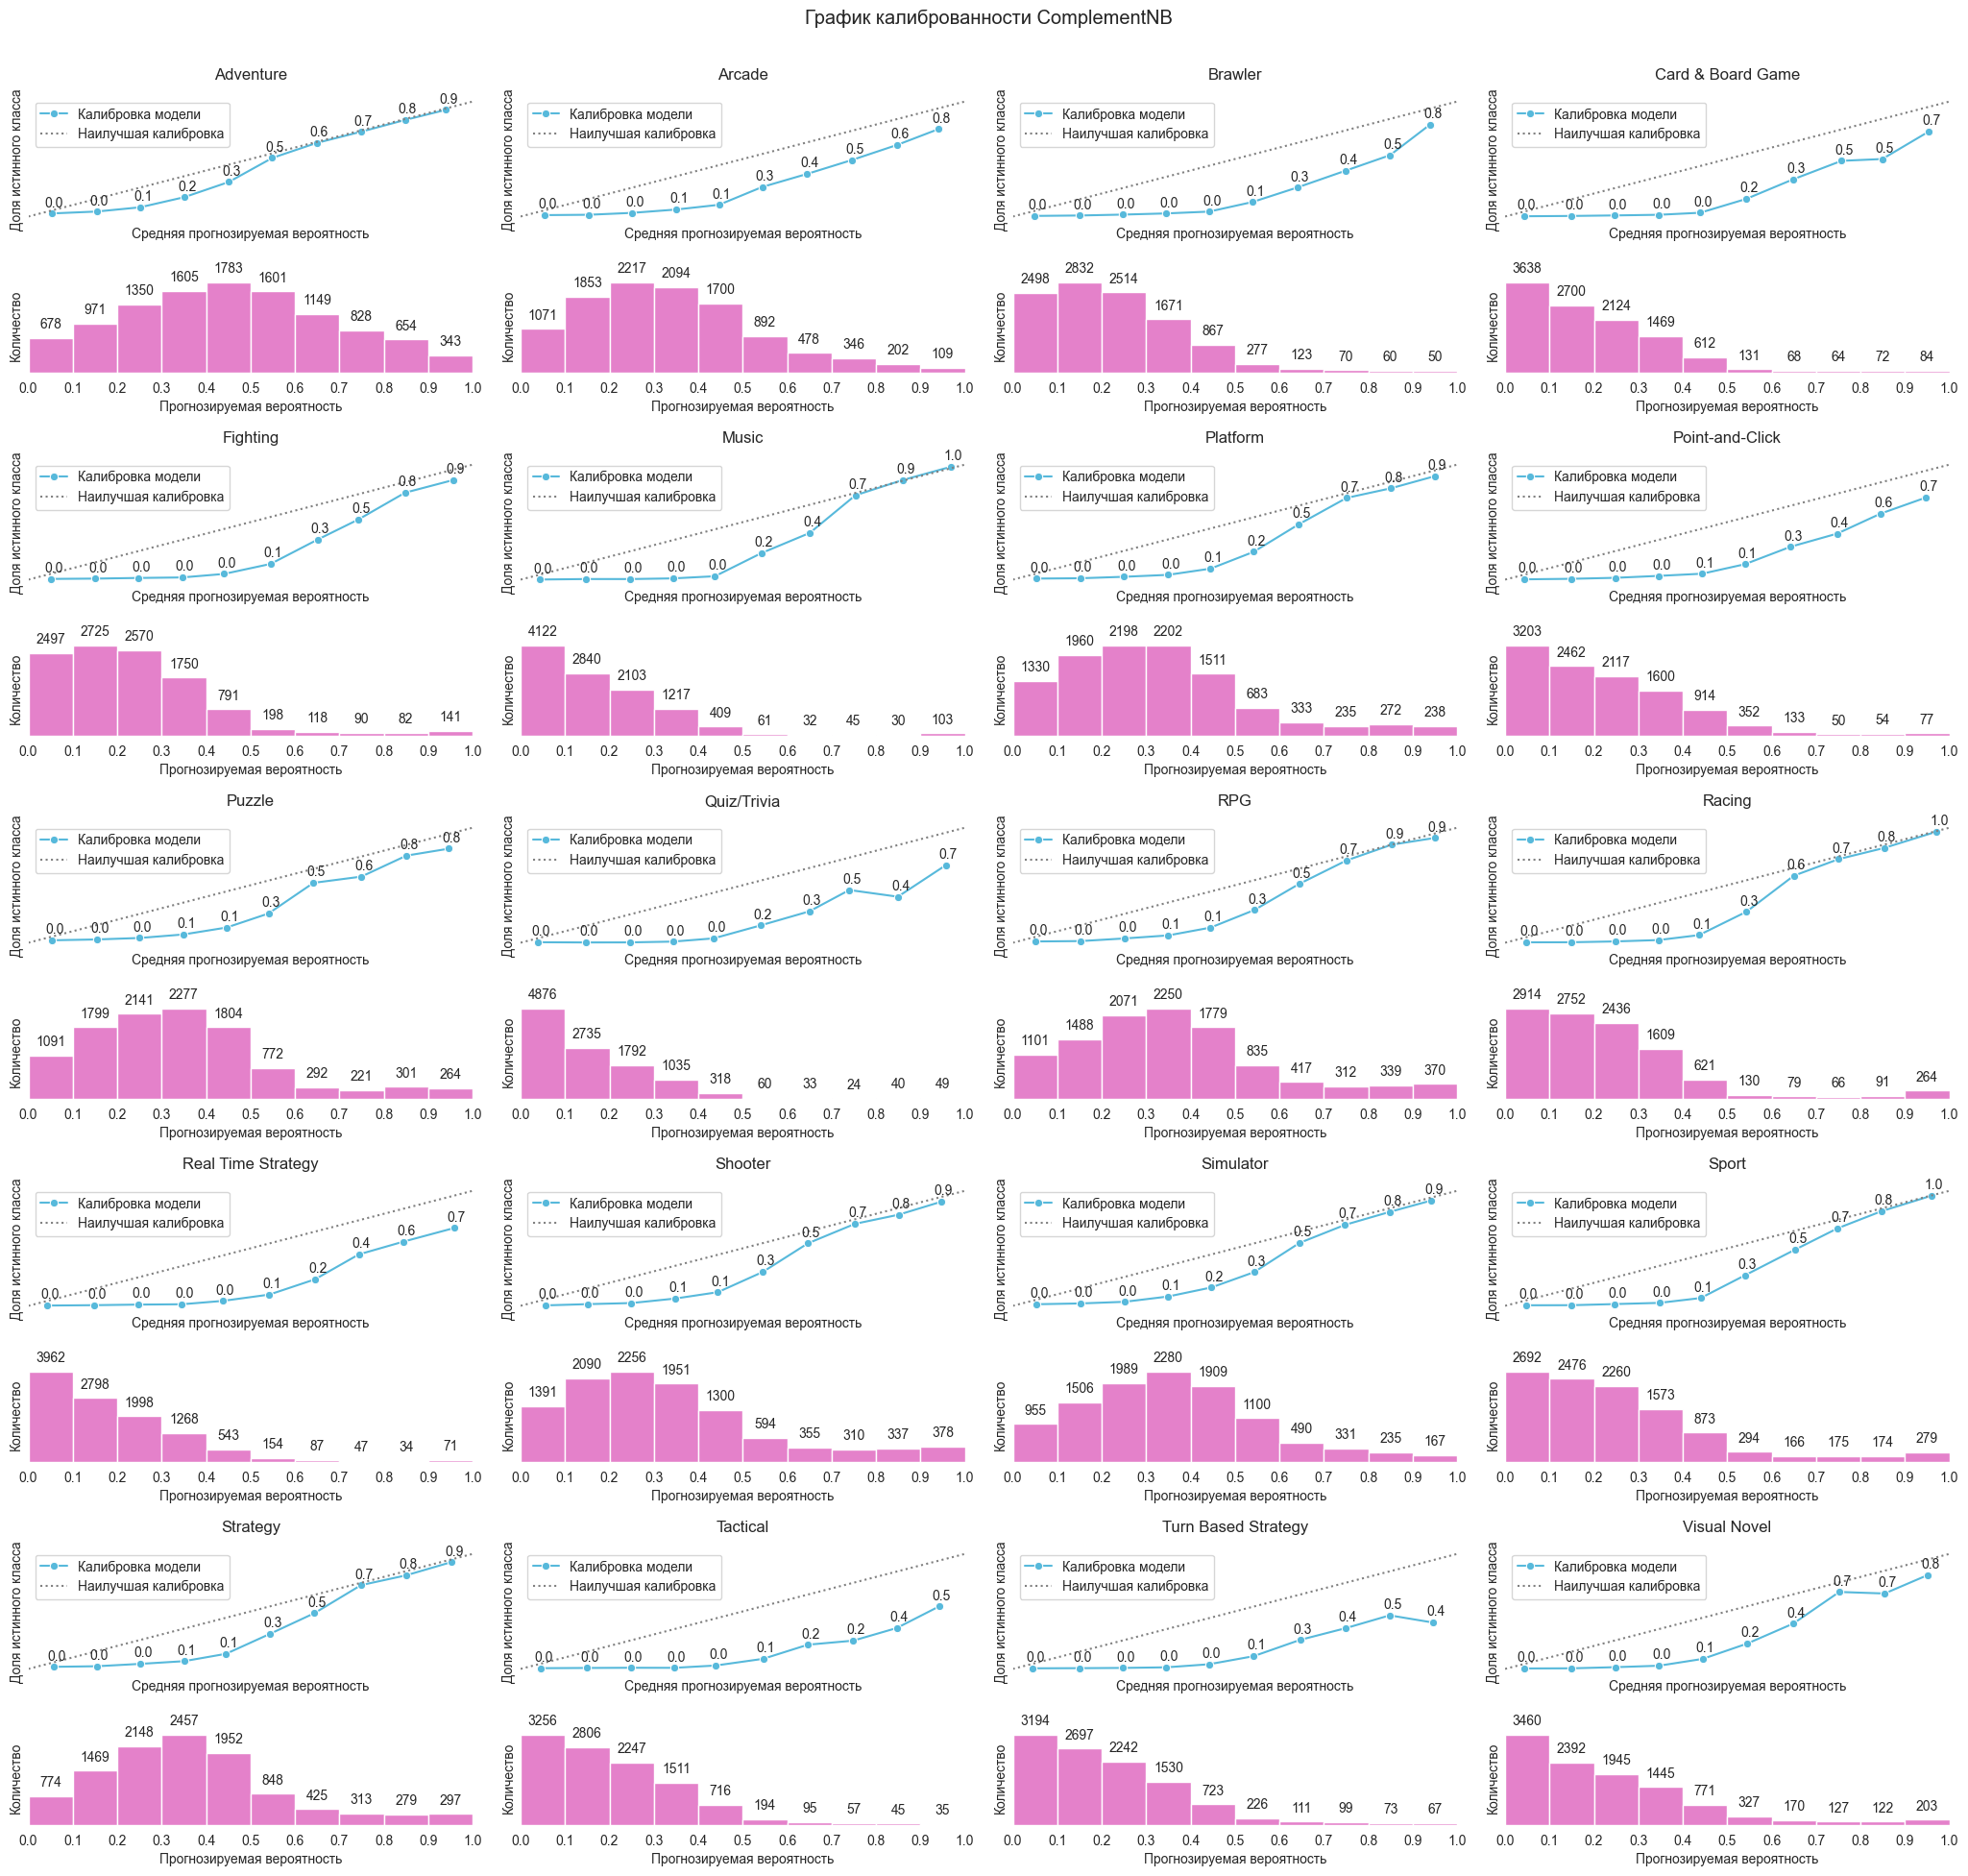

In [61]:
calibration.calibration(
    y_true=y_valid,
    y_proba=[pd.DataFrame(x) for x in predict_proba],
    labels=labels, 
    title='График калиброванности ComplementNB'
)

### Выводы по тестированию моделей
***

1. Для стандартизации признаков использован **TfidfVectorizer**.
2. Дляля оценки эффективности **предсказательной способности** модели использована метрика **f1-weighted**.
3. Для **оценки эффективности** были выбраны следующие показатели:
    - время обучения;
    - время предсказания;
    - f1-weighted.
4. ComplementNB:
    - результаты кросс-валидации:
        - среднее время обучения: от **15** до **20** сек.;
        - среднее время предсказания: от **3** до **5** сек.;
        - среднее значение f1-weighted: **0.58**.
    - оценка масштабируемости:
        - кривые обучения показывают, что **присутствует** признак переобучения модели;
        - **добавление новых данных** возможно **улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
    - на валидационной выборке значение f1-weighted - **0.60**
    - калиброванность модели:
        - модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
        - прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**;
        - вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми;
        - **необходима** калибровка модели.  
5. SGDClassifier:
    - результаты кросс-валидации:
        - среднее время обучения: от **15** до **25** сек.;
        - среднее время предсказания:от **3** до **5** сек.;
        - среднее значение f1-weighted: **0.60**.
    - оценка масштабируемости:
        - кривые обучения показывают, что **присутствует** признак переобучения модели;
        - **добавление новых данных не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
    - на валидационной выборке значение f1-weighted - **0.61**
    - калиброванность модели:
        - модель имеет **неплохую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
        - прогнозируемая вероятность распределена **неравномерно**, тем не менее, **отсутствуют** явно приобладающие диапазоны;
        - для более точного прогнозирования вероятности **необходима** калибровка модели.

## Генерация признаков
***

In [62]:
generator = FunctionTransformer(generate)
cleaner = ColumnTransformer(
    transformers=[
        ('preprocessor', FunctionTransformer(cleaning), [0]),
    ],
    remainder='passthrough'
)
preprocessor = Pipeline(
    steps=[
        ('generator', generator),
        ('cleaner', cleaner),
    ]
)
preprocessor

Pipeline(steps=[('generator',
                 FunctionTransformer(func=<function generate at 0x000001FAC50E1510>)),
                ('cleaner',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('preprocessor',
                                                  FunctionTransformer(func=<function cleaning at 0x000001FAC5113D90>),
                                                  [0])]))])

In [63]:
pd.DataFrame(preprocessor.fit_transform(x_train))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,namcot mahjong iii mahjong tengoku is a miscel...,122.0,103.0,0.0,0.0,20.0,0.0,0.0,103.0,0.0,0.844262,0.0,0.0,0.0,0.0,0.0,5.15
1,a relaxing puzzle game full of beautiful art f...,82.0,70.0,0.0,0.0,13.0,0.0,0.0,70.0,0.0,0.853659,0.0,0.0,0.0,0.0,0.0,5.384615
2,this compilation includes the base game f e a ...,95.0,76.0,0.0,0.0,20.0,0.0,0.0,76.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,3.8
3,fly the brand new ch huron and mi taru heavy l...,140.0,116.0,0.0,0.0,25.0,0.0,0.0,116.0,0.0,0.828571,0.0,0.0,0.0,0.0,0.0,4.64
4,enter gnorbert s dreamworld and explore his in...,176.0,147.0,0.0,0.0,30.0,0.0,0.0,147.0,0.0,0.835227,0.0,0.0,0.0,0.0,0.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51151,in that unforgettable age everything looks lik...,100.0,85.0,0.0,0.0,16.0,0.0,0.0,85.0,0.0,0.85,0.0,0.0,0.0,0.0,0.0,5.3125
51152,pac man the new adventures known in japan as h...,662.0,547.0,0.0,0.0,116.0,0.0,0.0,547.0,0.0,0.826284,0.0,0.0,0.0,0.0,0.0,4.715517
51153,don the parka and shovel of the santacorps sno...,103.0,86.0,0.0,0.0,18.0,0.0,0.0,86.0,0.0,0.834951,0.0,0.0,0.0,0.0,0.0,4.777778
51154,a pacman like blocks game but main character h...,80.0,65.0,0.0,0.0,16.0,0.0,0.0,65.0,0.0,0.8125,0.0,0.0,0.0,0.0,0.0,4.0625


### ComplementNB
***

In [64]:
vectorizer = TfidfVectorizer(
    analyzer='word',
)

standardizer = ColumnTransformer(
        transformers=[
            ('vectorizer', vectorizer, 0),
            ('scaler', MaxAbsScaler(), slice(1, None))
        ]
    )
standardizer

ColumnTransformer(transformers=[('vectorizer', TfidfVectorizer(), 0),
                                ('scaler', MaxAbsScaler(),
                                 slice(1, None, None))])

In [65]:
estimator = ComplementNB()
estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)]
)
pipeline

Pipeline(steps=[('standardizer',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  TfidfVectorizer(), 0),
                                                 ('scaler', MaxAbsScaler(),
                                                  slice(1, None, None))])),
                ('estimator',
                 MultiOutputClassifier(estimator=ComplementNB(), n_jobs=4))])

In [66]:
best_param = {
    "estimator__estimator__alpha": [2.0],
    "estimator__estimator__norm": [False],
    "standardizer__vectorizer__max_features": [500000],
    "standardizer__vectorizer__ngram_range": [(1, 3)],
    "standardizer__vectorizer__norm": [None],
    "standardizer__vectorizer__sublinear_tf": [False]
}

In [67]:
%%time
complement_nb = GridSearchCV(
    estimator=pipeline, 
    param_grid=best_param, 
    scoring=f1_weighted,
    error_score=0.0,
    cv=3, 
    verbose=3,
    refit=True
)
complement_nb.fit(preprocessor.fit_transform(x_train), y_train); 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.580 total time=  23.3s
[CV 2/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.584 total time=  23.8s
[CV 3/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.581 total time=  23.3s
CPU times: total: 1min 40s
Wall time: 1min 47s


In [68]:
cv_results = pd.DataFrame(
    data=complement_nb.cv_results_, 
).sort_values('rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__estimator__alpha,param_estimator__estimator__norm,param_standardizer__vectorizer__max_features,param_standardizer__vectorizer__ngram_range,param_standardizer__vectorizer__norm,param_standardizer__vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,18.398646,0.043716,5.161071,0.221242,2.0,False,500000,"(1, 3)",None,False,"{'estimator__estimator__alpha': 2.0, 'estimato...",0.580044,0.583553,0.580744,0.581447,0.001516,1


In [69]:
results.loc['ComplementNB', ('Со сгенерированными признаками', 'Время обучения')] = cv_results.loc[0, 'mean_fit_time']
results.loc['ComplementNB', ('Со сгенерированными признаками', 'Время предсказания')] = cv_results.loc[0, 'mean_score_time']
results.loc['ComplementNB', ('Со сгенерированными признаками', 'f1-weighted')] = cv_results.loc[0, 'mean_test_score']

### SGDClassifier
***

In [70]:
vectorizer = TfidfVectorizer(
    analyzer='word',
)

standardizer = ColumnTransformer(
        transformers=[
            ('vectorizer', vectorizer, 0),
            ('scaler', MaxAbsScaler(), slice(1, None))
        ]
    )
standardizer

ColumnTransformer(transformers=[('vectorizer', TfidfVectorizer(), 0),
                                ('scaler', MaxAbsScaler(),
                                 slice(1, None, None))])

In [71]:
estimator = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    random_state=42
)
estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)]
)
pipeline

Pipeline(steps=[('standardizer',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  TfidfVectorizer(), 0),
                                                 ('scaler', MaxAbsScaler(),
                                                  slice(1, None, None))])),
                ('estimator',
                 MultiOutputClassifier(estimator=SGDClassifier(loss='log_loss',
                                                               penalty='elasticnet',
                                                               random_state=42),
                                       n_jobs=4))])

In [72]:
best_param = {
    "estimator__estimator__alpha": [0.1],
    "estimator__estimator__class_weight": ["balanced"],
    "estimator__estimator__l1_ratio": [0.0],
    "standardizer__vectorizer__max_features": [1000000],
    "standardizer__vectorizer__ngram_range": [(1, 3)],
    'standardizer__vectorizer__sublinear_tf': [True],
    "standardizer__vectorizer__norm": [None]
}

In [73]:
%%time
sgd = GridSearchCV(
    estimator=pipeline, 
    param_grid=best_param, 
    scoring=f1_weighted,
    error_score=0.0,
    cv=3, 
    verbose=3,
    refit=True
)
sgd.fit(preprocessor.fit_transform(x_train), y_train); 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=True;, score=0.613 total time=  37.1s
[CV 2/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=True;, score=0.616 total time=  33.1s
[CV 3/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer_

In [74]:
cv_results = pd.DataFrame(
    data=sgd.cv_results_, 
).sort_values('rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__estimator__alpha,param_estimator__estimator__class_weight,param_estimator__estimator__l1_ratio,param_standardizer__vectorizer__max_features,param_standardizer__vectorizer__ngram_range,param_standardizer__vectorizer__norm,param_standardizer__vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,29.65671,1.391357,4.819988,0.540968,0.1,balanced,0.0,1000000,"(1, 3)",None,True,"{'estimator__estimator__alpha': 0.1, 'estimato...",0.612855,0.616033,0.61395,0.61428,0.001318,1


In [75]:
results.loc['SGDClassifier', ('Со сгенерированными признаками', 'Время обучения')] = cv_results.loc[0, 'mean_fit_time']
results.loc['SGDClassifier', ('Со сгенерированными признаками', 'Время предсказания')] = cv_results.loc[0, 'mean_score_time']
results.loc['SGDClassifier', ('Со сгенерированными признаками', 'f1-weighted')] = cv_results.loc[0, 'mean_test_score']

### Выводы по генерации признаков
***

1. Были сгенерированы следующие признаки:
    - количество символов;
    - количество букв;
    - количество цифр;
    - количество знаков пунктуации;
    - количество слов;
    - количество слов с заглавной буквы;
    - количество слов в верхнем регистре;
    - количество слов в нижнем регистре;
    - количество предложений;
    - отношение количества букв к количеству символов;
    - отношение количества цифр к количеству символов;
    - отношение количества знаков пунктуации к количеству символов;
    - sотношение количества предложений к количеству слов;
    - отношение количества слов, начинающихся с заглавной буквы к количеству слов;
    - отношение количества слов в верхнем регистре к количеству слов;
    - отношение количества слов в нижнем регистре к количеству слов.
2. При генерировании признаков, был использован текст не прошедший предобработку.
3. ComplementNB:
    - среднее время обучения: от **15** до **25** сек.;
    - среднее время предсказания: **3** до **5** сек.;
    - среднее значение f1-weighted: **0.579**.
4. SGDClassifier:
    - среднее время обучения: от **20** до **30** сек.;
    - среднее время предсказания: **3** до **5** сек.;
    - среднее значение f1-weighted: **0.612**.

## Проверка модели на тестовой выборке
***

In [76]:
(results
 .style
 .format(lambda x: f'{x:.3f}'))

In [77]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', sgd.best_estimator_)]
)
pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('generator',
                                  FunctionTransformer(func=<function generate at 0x000001FAC50E1510>)),
                                 ('cleaner',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('preprocessor',
                                                                   FunctionTransformer(func=<function cleaning at 0x000001FAC5113D90>),
                                                                   [0])]))])),
                ('model',
                 Pipeline(steps=[('standardizer',
                                  ColumnTransformer(transformers=[('vectorizer',
                                                                   TfidfVectorizer(max_features=1000000,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   norm=None,
                                                                                   sublinear_tf=True),
                                                                   0),
                                                                  ('scaler',
                                                                   MaxAbsScaler(),
                                                                   slice(1, None, None))])),
                                 ('estimator',
                                  MultiOutputClassifier(estimator=SGDClassifier(alpha=0.1,
                                                                                class_weight='balanced',
                                                                                l1_ratio=0.0,
                                                                                loss='log_loss',
                                                                                penalty='elasticnet',
                                                                                random_state=42),
                                                        n_jobs=4))]))])

In [78]:
predict = pipeline.predict(x_test)

In [79]:
f1 = f1_score(
    y_true=y_test,
    y_pred=predict,
    average='weighted'
)

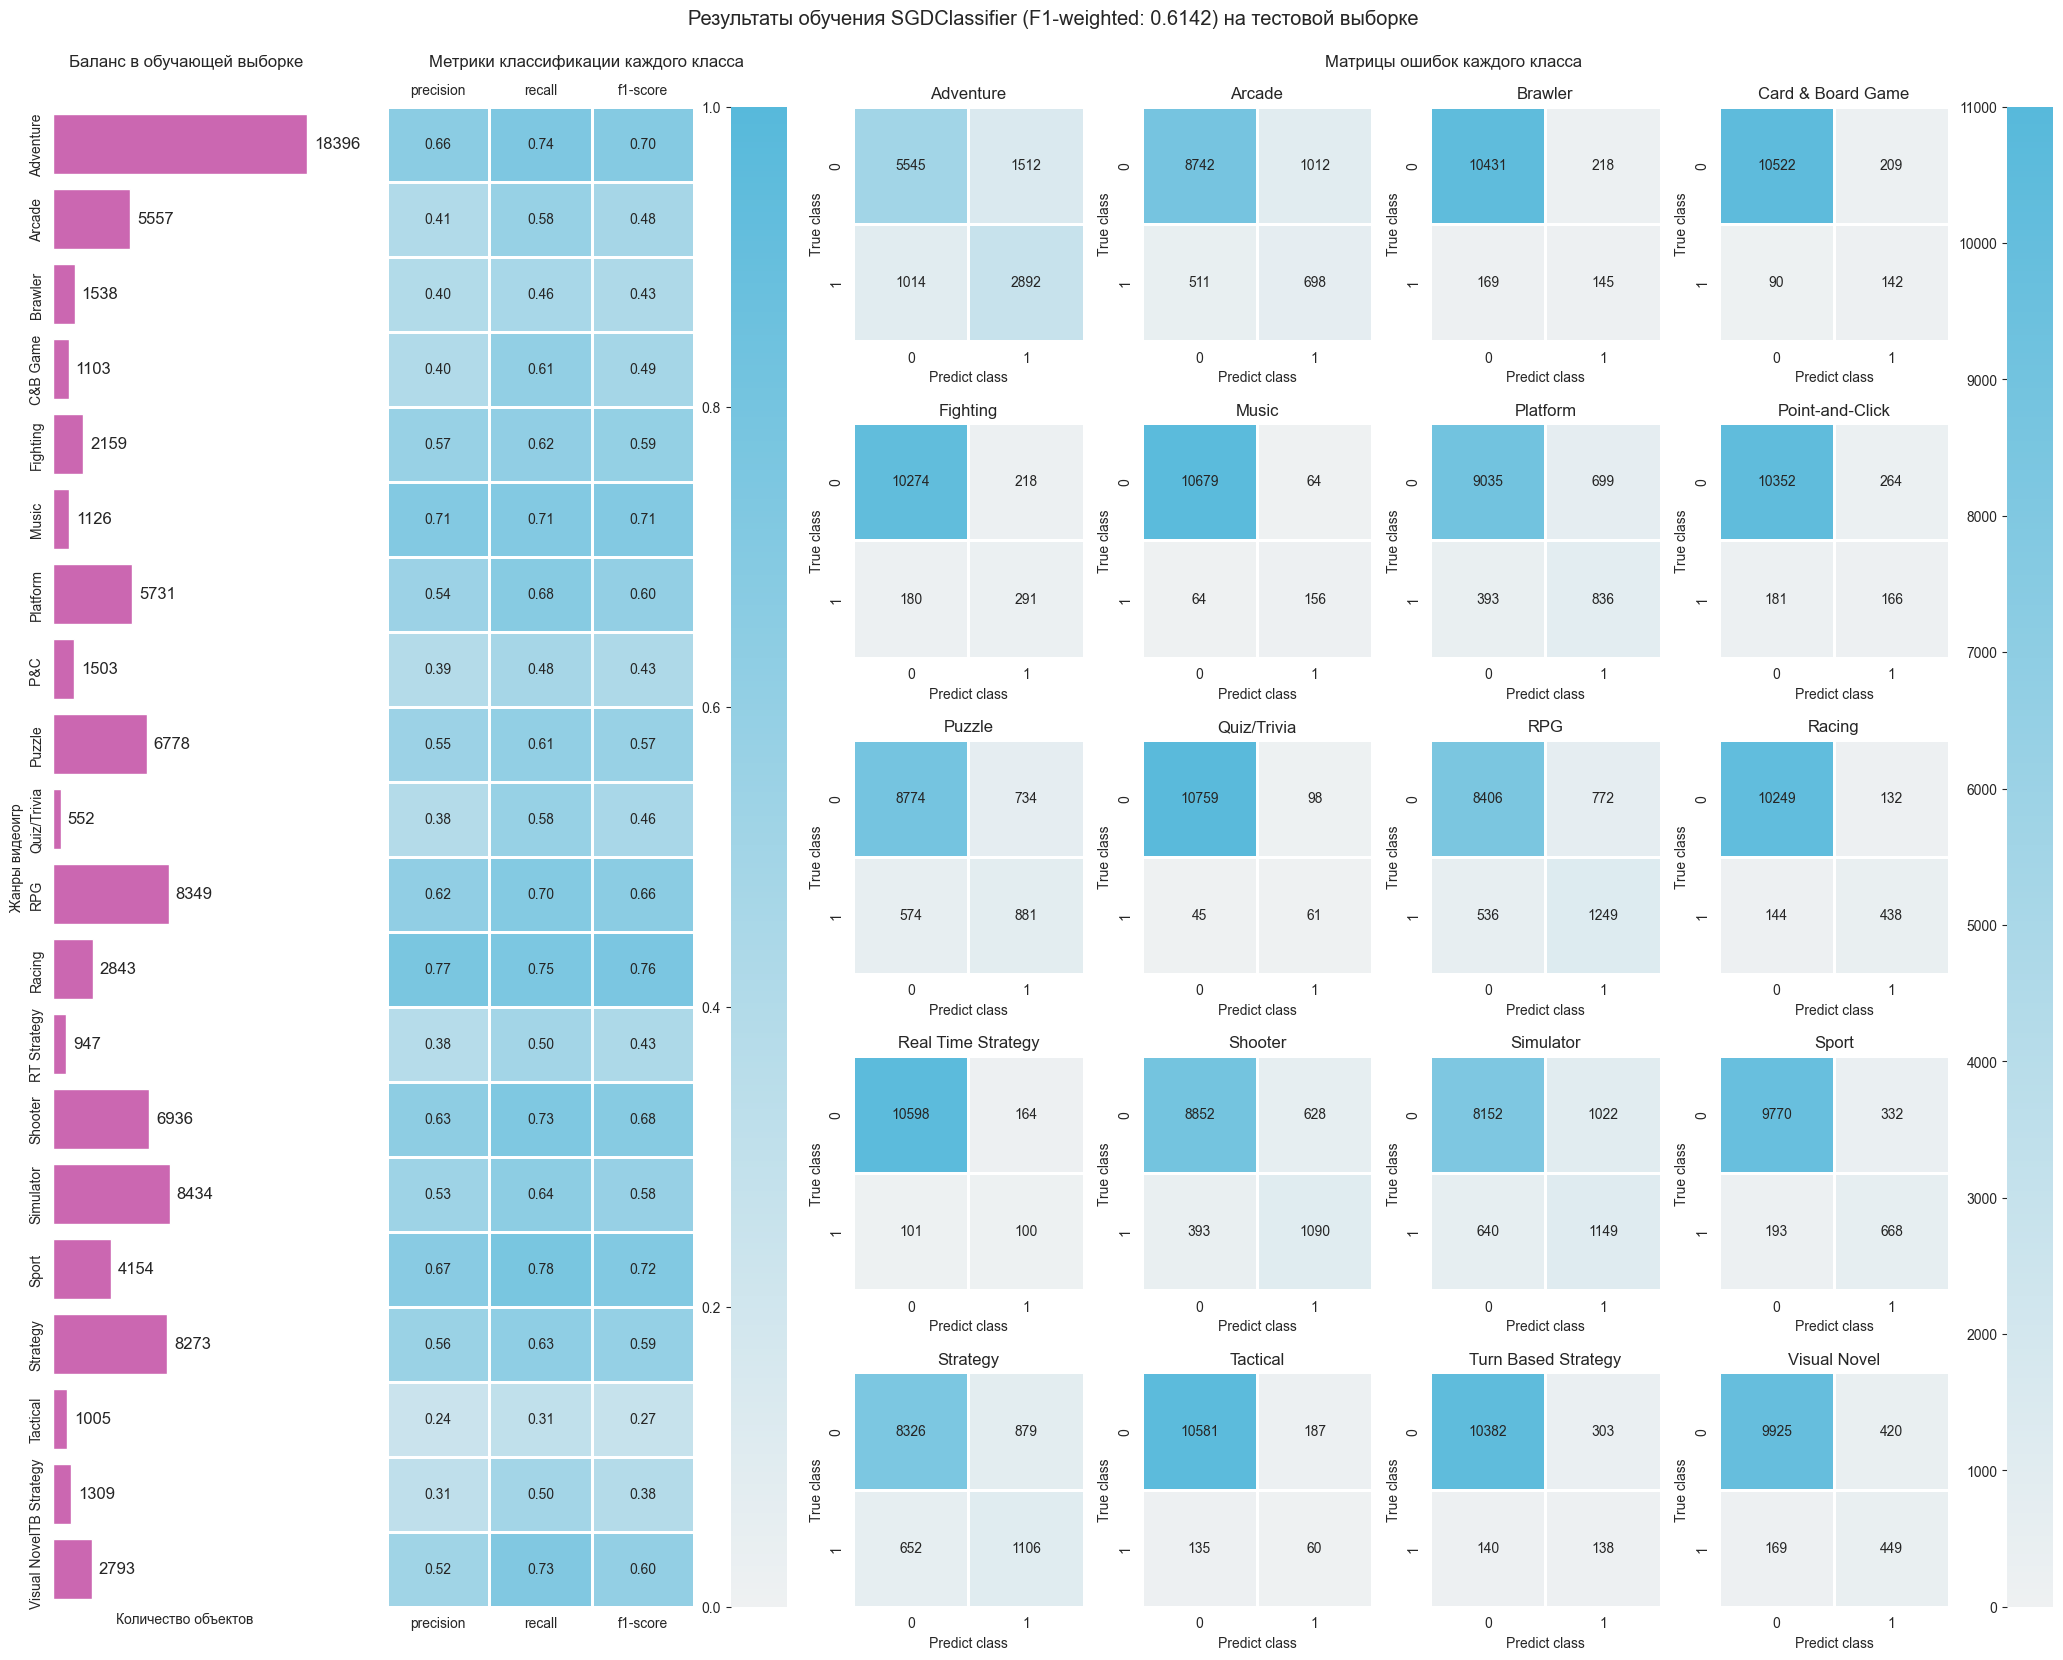

In [80]:
metrics.metrics(
    y_test=y_test,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения SGDClassifier '
          f'(F1-weighted: {f1:.4f}) на тестовой выборке',
    labels=labels
)

# Выводы
***

1. Анализ баланса классов:
   - в наборе данных **присутствует дисбаланс классов**;
   - **мажоритарным** классом является класс **Adventure** (количество экземпляров более **22 тыс.**);
   - **миноритарным** классом является класс **Quiz/Trivia** (количество экземпляров менее **1 тыс.**);
   - **остальные** классы имеют от **1000** до **10 тыс.** экземпляров.
2. Предобработка текста:
    - в ходе предобработки текста удалены все символы, отличные от симвволов **английского алфавита**.
3. Частотный анализ:
    - наиболее часто в описаниях видеоигр встречается слово **game** (приблизительно **60 тыс.** раз);
    - **остальные слова** встречаются в описаниях видеоигр менее **17 тыс.** раз;
    - для каждого класса существует свой **уникальный** список наиболее часто встречающихся слов в описаниях видеоигр.
4. Тестирование моделей:
    - для стандартизации признаков использован **TfidfVectorizer**;
    - для оценки эффективности **предсказательной способности** модели использована метрика **f1-weighted**;
    - В для **оценки эффективности** были выбраны следующие показатели:
        - время обучения;
        - время предсказания;
        - f1-weighted.
    1. ComplementNB:
        - результаты кросс-валидации:
            - среднее время обучения:от **15** до **20** сек.;
            - среднее время предсказания: от **3** до **5** сек.;
            - среднее значение f1-weighted: **0.586**.
        - оценка масштабируемости:
            - кривые обучения показывают, что **присутствует** признак переобучения модели;
            - **добавление новых данных** возможно **улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
        - на валидационной выборке значение f1-weighted - **0.604**
        - калиброванность модели:
            - модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
            - прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**;
            - вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми;
            - **необходима** калибровка модели.  
    2. SGDClassifier:
        - результаты кросс-валидации:
            - среднее время обучения: от **15** до **25** сек.;
            - среднее время предсказания: от **3** до **5** сек.;
            - среднее значение f1-weighted: **0.611**.
        - оценка масштабируемости:
            - кривые обучения показывают, что **присутствует** признак переобучения модели;
            - **добавление новых данных не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
        - на валидационной выборке значение f1-weighted - **0.614**
        - калиброванность модели:
            - модель имеет **неплохую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
            - прогнозируемая вероятность распределена **неравномерно**, тем не менее, **отсутствуют** явно приобладающие диапазоны;
            - для более точного прогнозирования вероятности **необходима** калибровка модели.
5. Генерация признаков:
    - были сгенерированы следующие признаки:
        - количество символов;
        - количество букв;
        - количество цифр;
        - количество знаков пунктуации;
        - количество слов;
        - количество слов с заглавной буквы;
        - количество слов в верхнем регистре;
        - количество слов в нижнем регистре;
        - количество предложений;
        - отношение количества букв к количеству символов;
        - отношение количества цифр к количеству символов;
        - отношение количества знаков пунктуации к количеству символов;
        - sотношение количества предложений к количеству слов;
        - отношение количества слов, начинающихся с заглавной буквы к количеству слов;
        - отношение количества слов в верхнем регистре к количеству слов;
        - отношение количества слов в нижнем регистре к количеству слов.
    - При генерировании признаков, был использован текст не прошедший предобработку.
    1. ComplementNB:
        - среднее время обучения: **15** до **25** сек.;
        - среднее время предсказания: **3** до **5** сек.;
        - среднее значение f1-weighted: **0.581**.
    2. SGDClassifier:
        - среднее время обучения: **20** до **30** сек.;
        - среднее время предсказания: **3** до **5** сек.;
        - среднее значение f1-weighted: **0.614**.
6. Проверка модели на тестовой выборке:
    - выбрана модель **SGDClassifier** с **генерацией признаков**;
    - значение f1-weighted: **0.614**.